# 1. Fitting Ne lines in a loop
- This is the first step of fitting Diad data
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- You can install DiadFit through PyPI, simply uncomment this line. You only need to run this once per computer (until you want to get an upgraded version)
- Uncomment this line if you havent installed DiadFit, or are running a much older version. 

In [1]:
#!pip install --upgrade DiadFit

## Now import the packages you need
- When you communicate bugs with Penny, make sure you specify the version here.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
# This needs to be 0.0.68 or higher!
pf.__version__

'1.0.2'

##  Specifying paths
- Put your path here, e.g. where in your computer the spectra and metadata are saved

In [3]:
import os
DayFolder=os.getcwd()

if os.name=='posix':
    slash='/'
else:
    slash='\\'

meta_path=DayFolder +slash+ 'MetaData'
spectra_path=DayFolder +slash+ 'Spectra'

# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=True
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=True
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)


Good job! Filetype headless_txt is valid.


In [4]:
# This step gets all your Ne files. Enter ID_str as a string in only your Neon files, exclude strings not in Ne files. So here we take files with 'Ne' in the name and exclude those with 'diad' in the name. 
Ne_files=pf.get_files(path=spectra_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad','Series'], sort=False)

Ne_files

['01 Ne--000--Spec.Data 1.txt',
 '02 Ne--Spectrum--001--Spec.Data 1.txt',
 '05 Ne--Spectrum--011--Spec.Data 1.txt',
 '08 Ne--Spectrum--019--Spec.Data 1.txt',
 '15 Ne--Spectrum--027--Spec.Data 1.txt',
 '18 Ne--Spectrum--040--Spec.Data 1.txt',
 '21 Ne--Spectrum--051--Spec.Data 1.txt',
 '25 Ne--Spectrum--059--Spec.Data 1.txt',
 '27 Ne--Spectrum--067--Spec.Data 1.txt',
 '36 Ne--Spectrum--081--Spec.Data 1.txt',
 '39 Ne--Spectrum--087--Spec.Data 1.txt',
 '46 Ne--Spectrum--103--Spec.Data 1.txt',
 '52 Ne--Spectrum--113--Spec.Data 1.txt',
 '68 Ne--Spectrum--145--Spec.Data 1.txt',
 '70 Ne--Spectrum--147--Spec.Data 1.txt']

### Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [5]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, 
cut_off_intensity=2000)
df_Ne.iloc[1:7]

Raman_shift (cm-1)  Intensity  Ne emission line in air
15          818.699523     5000.0                556.27662
23         1117.086987     5000.0                565.66588
30         1310.480205     5000.0                571.92248
33         1398.915133     5000.0                574.82985
37         1447.564622     7000.0                576.44188
40         1567.204978     5000.0                580.44496

### Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for each selected line

In [6]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
line1_shift=line_1, line2_shift=line_2,
cut_off_intensity=2000)
ideal_split

Ne_Split       Line_1       Line_2  Line_1_int  Line_2_int  \
0  330.477634  1117.086987  1447.564622      5000.0      7000.0   

   Entered Pos Line 1  Entered Pos Line 2  
0                1117                1447

## Select one file to tweak the fit for
- You can either do this numerically, or by specifiying the filename between ''

In [7]:
i=0 # Select one file
filename=Ne_files[i] 
print(filename)

01 Ne--000--Spec.Data 1.txt


## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook
- This also prints the heights of the other peaks so you could choose other Neons if you wanted to

Peak1_cent  Peak1_height   Peak2_cent  Peak2_height   Peak1_prom  \
0  1116.16583        4674.0  1447.663174   56902.66797  3954.100018   

     Peak2_prom  
0  56182.767988

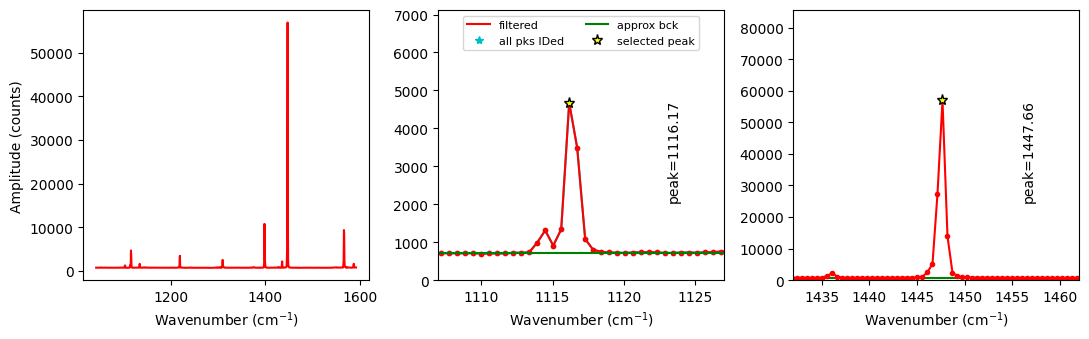

In [8]:
exclude_range_1=None
exclude_range_2=None

Neon_id_config=pf.Neon_id_config(height=10,  distance=1, prominence=10, 
            width=1, threshold=0.6,
            peak1_cent=line_1, peak2_cent=line_2, n_peaks=6, 
            exclude_range_1=exclude_range_1, 
            exclude_range_2=exclude_range_2)
Neon_id_config

Ne, df_fit_params=pf.identify_Ne_lines(path=spectra_path,
filename=filename, filetype=spectra_filetype,
config=Neon_id_config, print_df=False)
df_fit_params

### Tweak peak parameters
- One important thing is the background positions, these are defined relative to the peak position. Once you tweak them for each instrument, you chould be good to go. 
- Another thing is how many peaks you want for Peak1, 'peaks_1', for the 1117 line, you'll need 2 if you have the clear secondary peak seen above. 

In [9]:
pf.Ne_peak_config()

Ne_peak_config(model_name='PseudoVoigtModel', N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), peaks_1=2, peaks_2=1, DeltaNe_ideal=330.477634, x_range_baseline_pk1=20, y_range_baseline_pk1=200, x_range_baseline_pk2=20, y_range_baseline_pk2=200, pk1_sigma=0.4, pk2_sigma=0.4, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), LH_offset_mini2=None, x_span_pk1=None, x_span_pk2=None)

In [10]:
model_name='PseudoVoigtModel'
Ne_Config_est=pf.pf.Ne_peak_config(model_name=model_name,
 DeltaNe_ideal=ideal_split['Ne_Split'], peaks_1=2, LH_offset_mini=[0.5, 3],
pk1_sigma=0.6, pk2_sigma=0.3,
lower_bck_pk1=(-40, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=5, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10],
N_poly_pk2_baseline=2 )

filename  1σ_Ne_Corr_test  1σ_Ne_Corr  pk2_peak_cent  \
0  Ne--000--Spec.Data 1.txt         0.000039    0.000039    1447.567456   

   pk2_amplitude  pk2_sigma pk2_gamma  error_pk2  Peak2_Prop_Lor  \
0   57803.826163   0.400407      None   0.001841        0.415903   

   pk1_peak_cent  ...  Peak1_Prop_Lor     deltaNe   Ne_Corr  Ne_Corr_min  \
0    1116.367072  ...        0.372385  331.200384  0.997818     0.997774   

   Ne_Corr_max  residual_pk2  residual_pk1  residual_pk1+pk2  \
0     0.997862    144.163141     13.371438        157.534579   

   error_pk1_amplitude  error_pk2_amplitude  
0           217.466187           353.565917  

[1 rows x 24 columns]

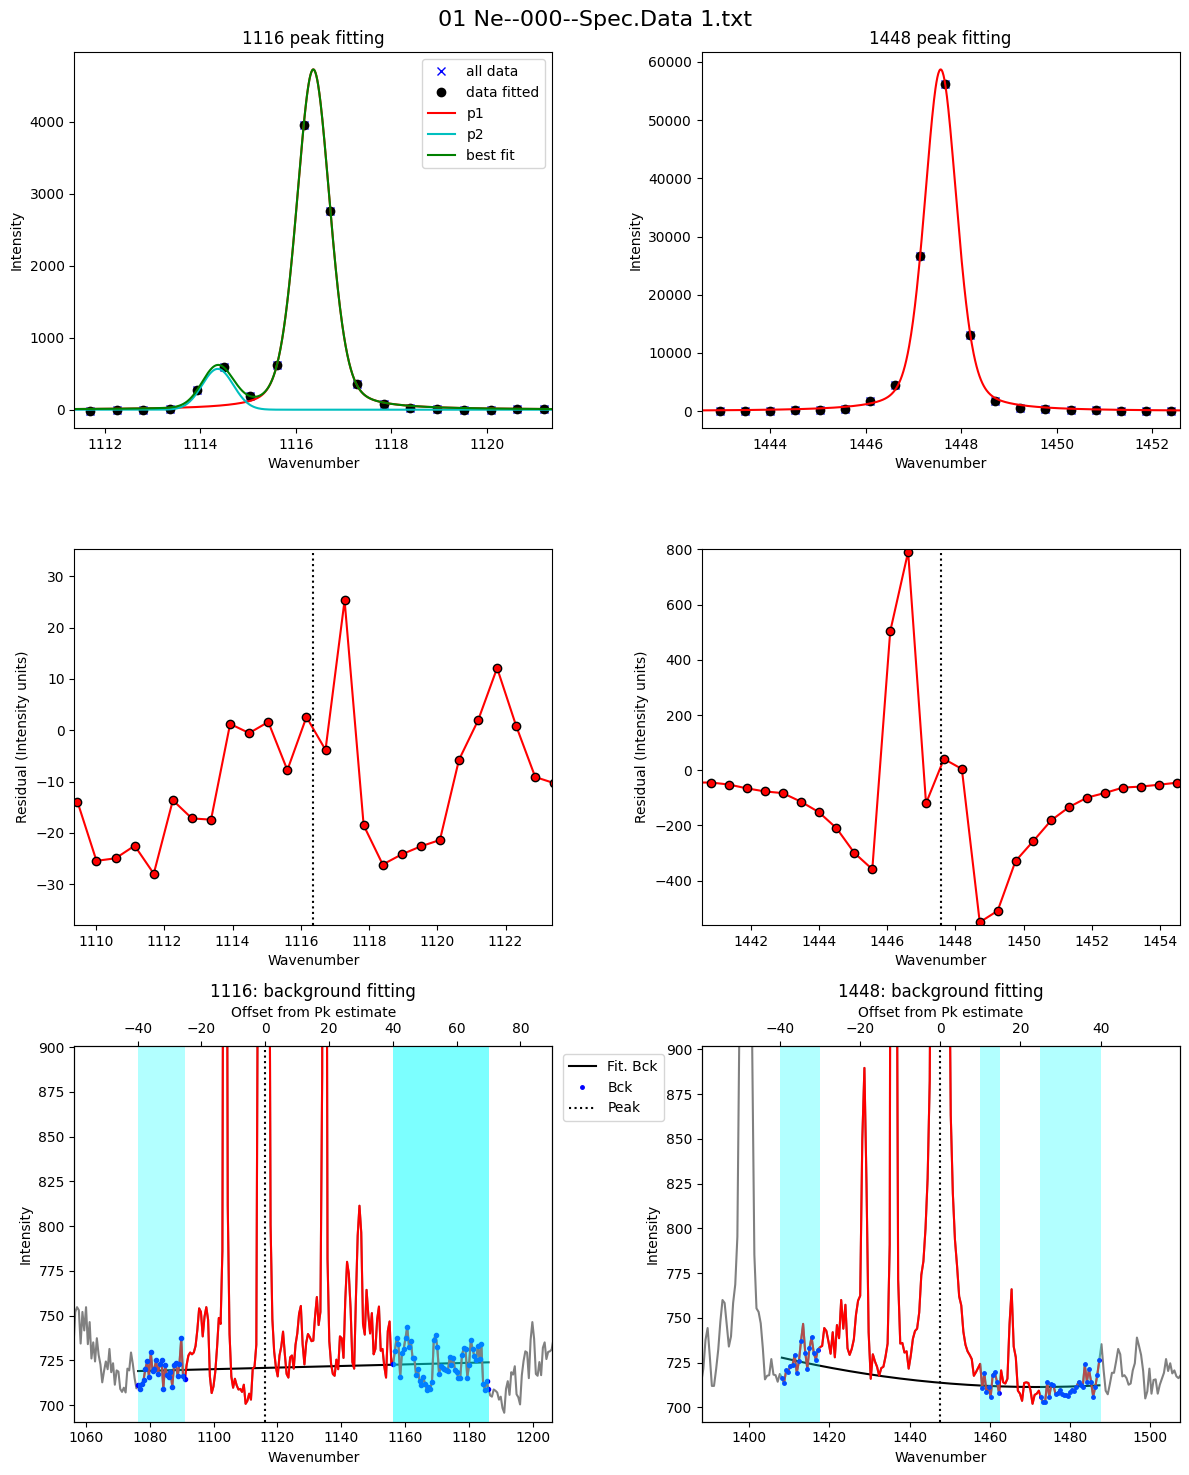

In [11]:

df_test_params=pf.fit_Ne_lines(Ne=Ne, filename=filename,
path=spectra_path, prefix=prefix,
config=Ne_Config_est,
    Ne_center_1=df_fit_params['Peak1_cent'].iloc[0], 
    Ne_center_2=df_fit_params['Peak2_cent'].iloc[0],
    Ne_prom_1=df_fit_params['Peak1_prom'].iloc[0],
    Ne_prom_2=df_fit_params['Peak2_prom'].iloc[0],
    const_params=False)                                                                 
                                                                     
display(df_test_params)

In [12]:
## Now tweak the values of the sigma to help with the looping - then for looping we let these parameters only vary +-20% between spectra
Ne_Config_est.pk1_sigma=df_test_params['pk1_sigma'][0]
Ne_Config_est.pk2_sigma=df_test_params['pk2_sigma'][0]


## Now fit all Ne files here using these parameters. 
- If you select plot_figure=False, the loop will be quick. 
- But if its True, you can to inspect the figures.

  0%|          | 0/15 [00:00<?, ?it/s]

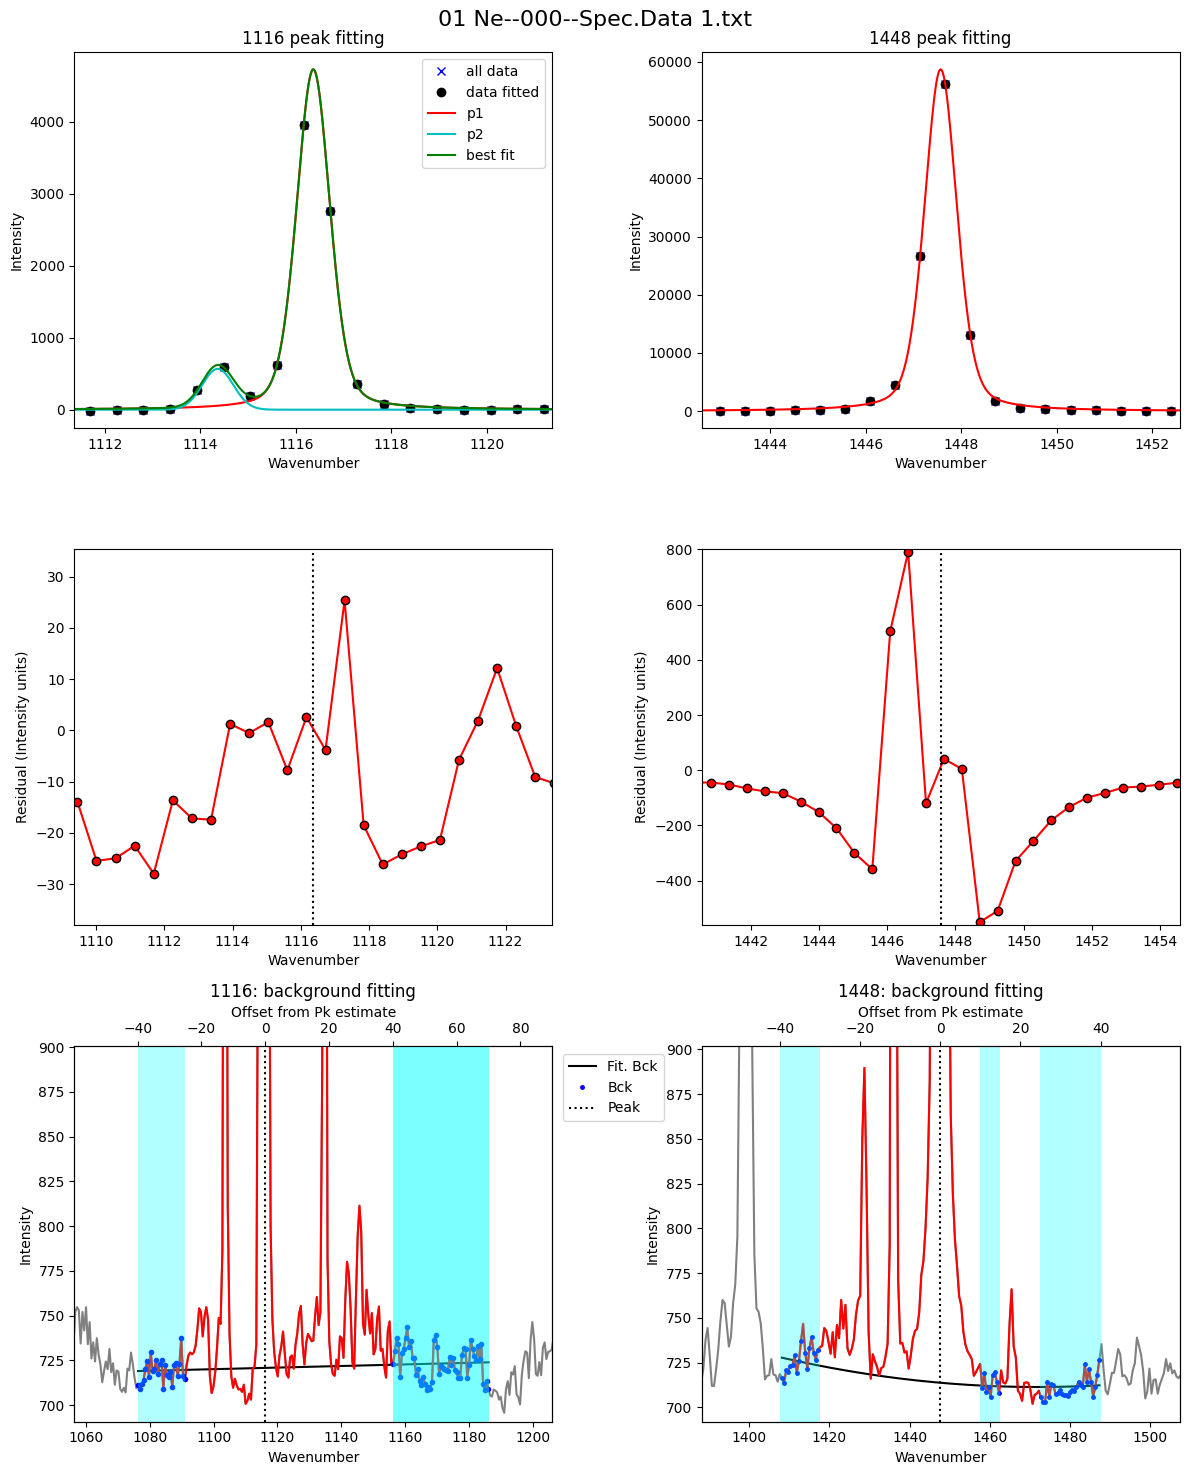

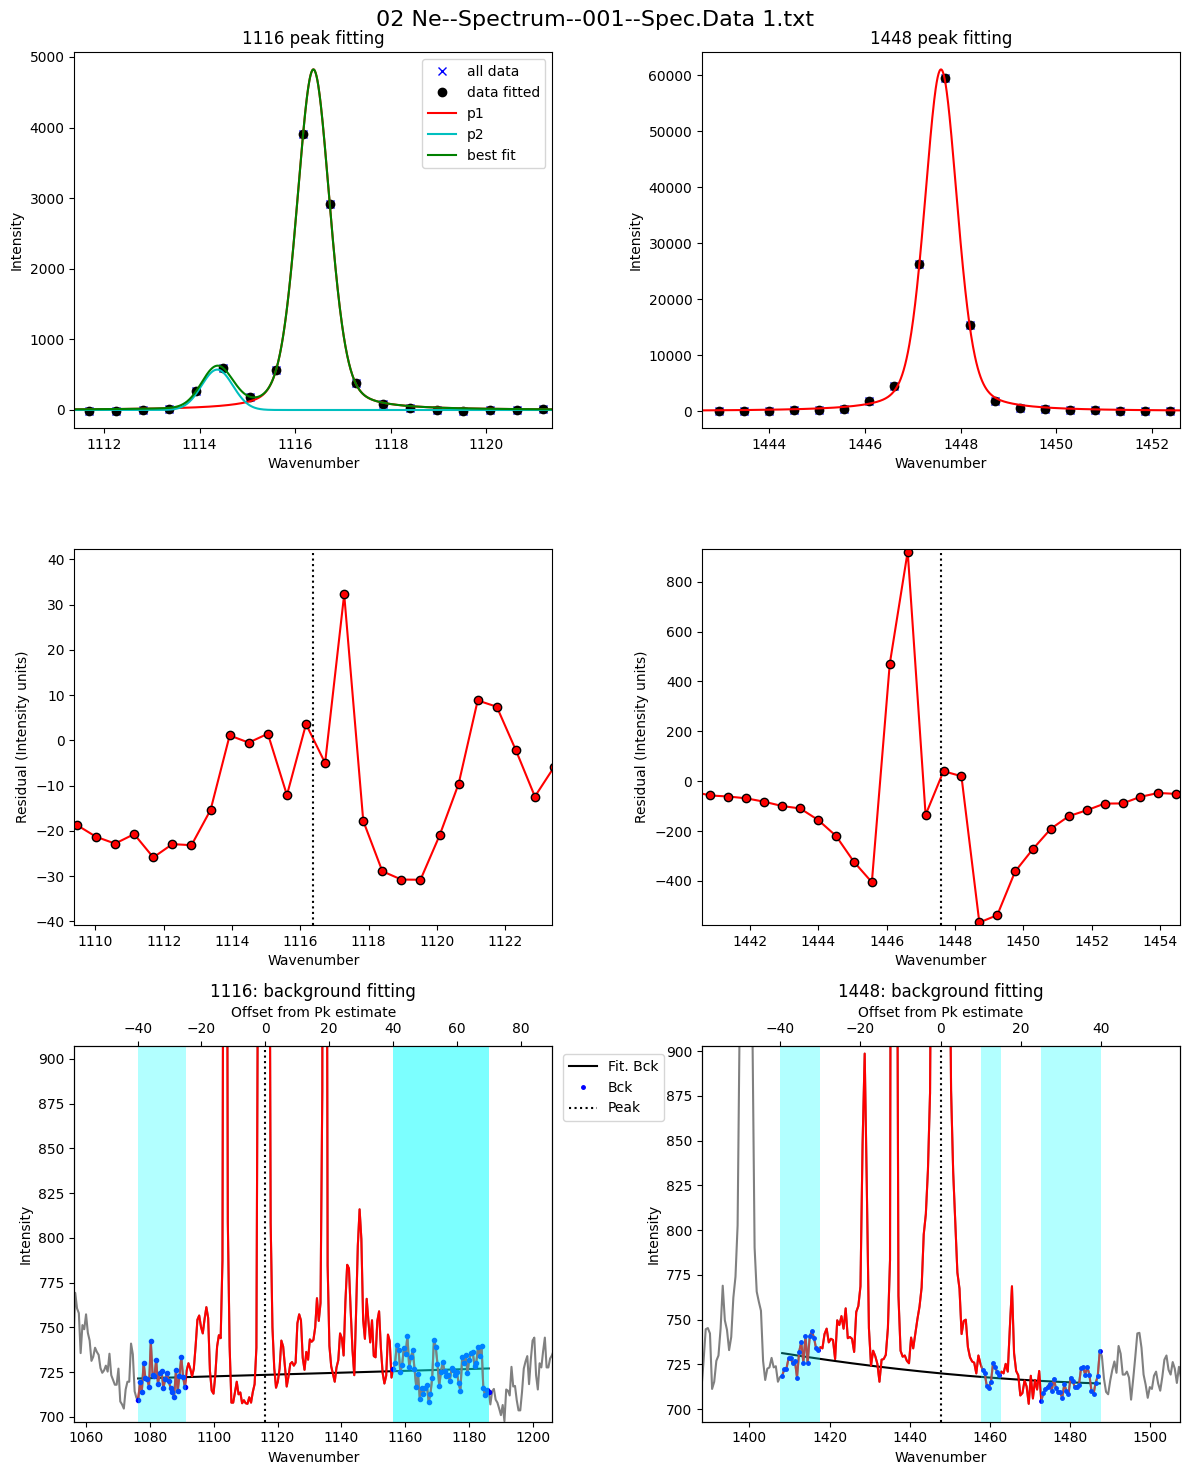

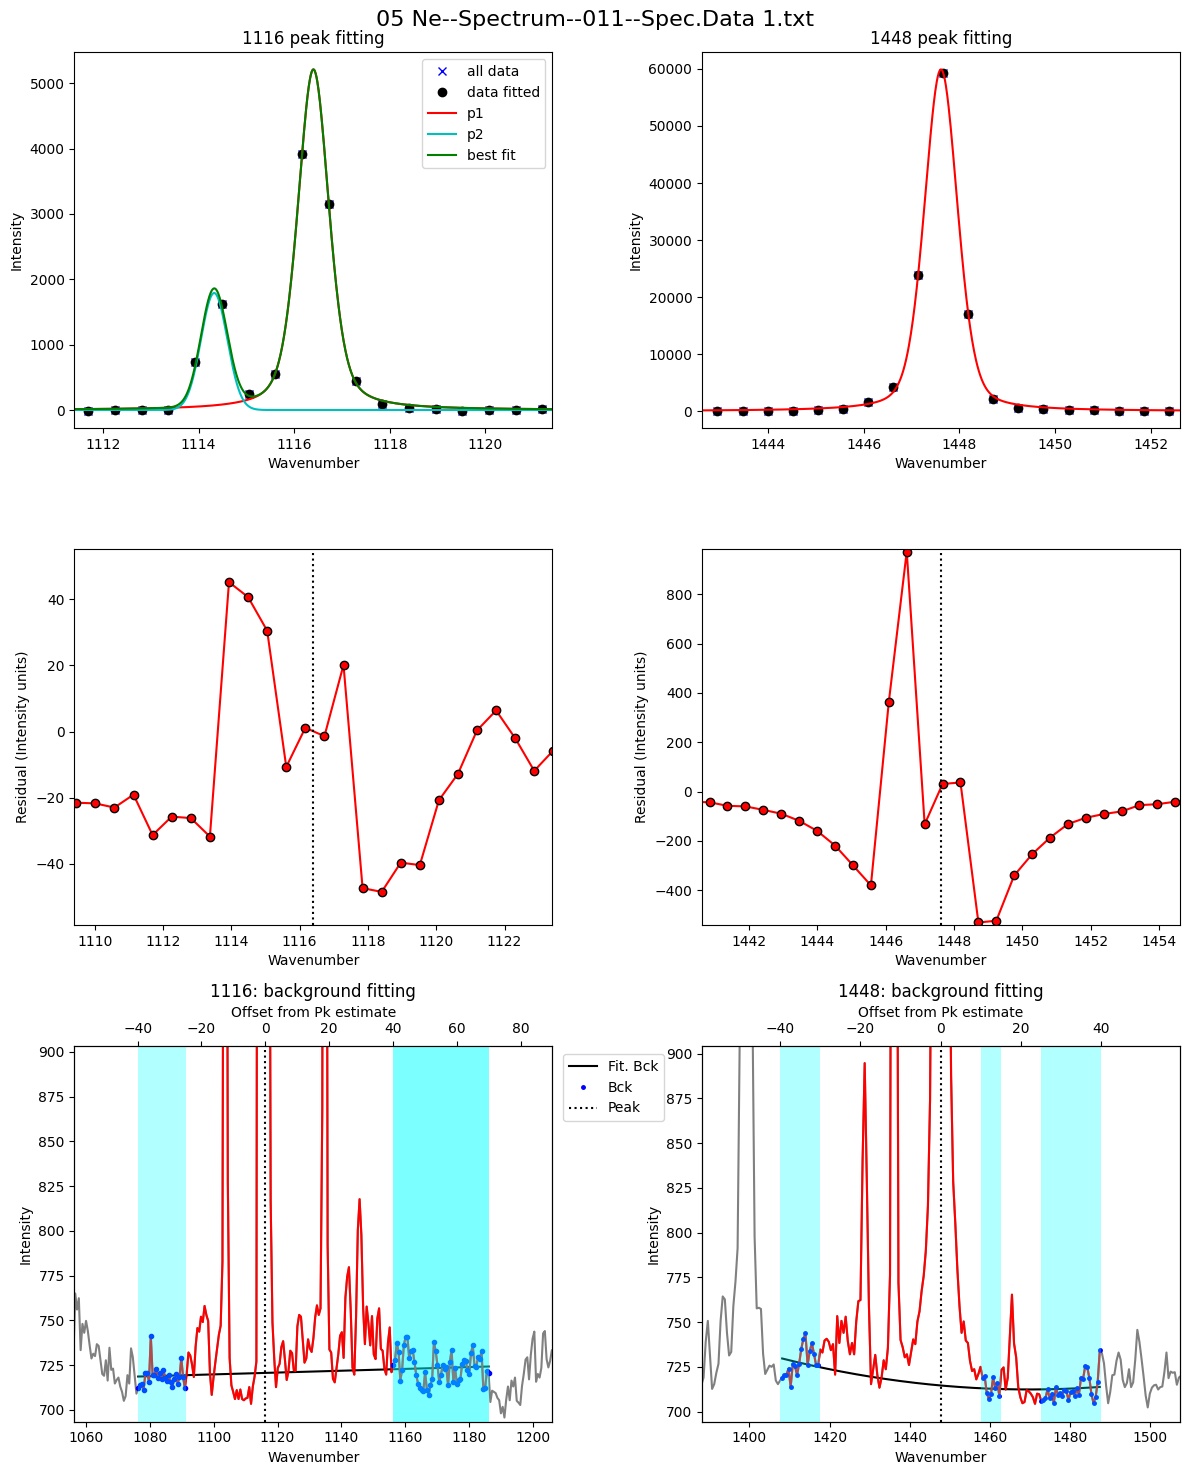

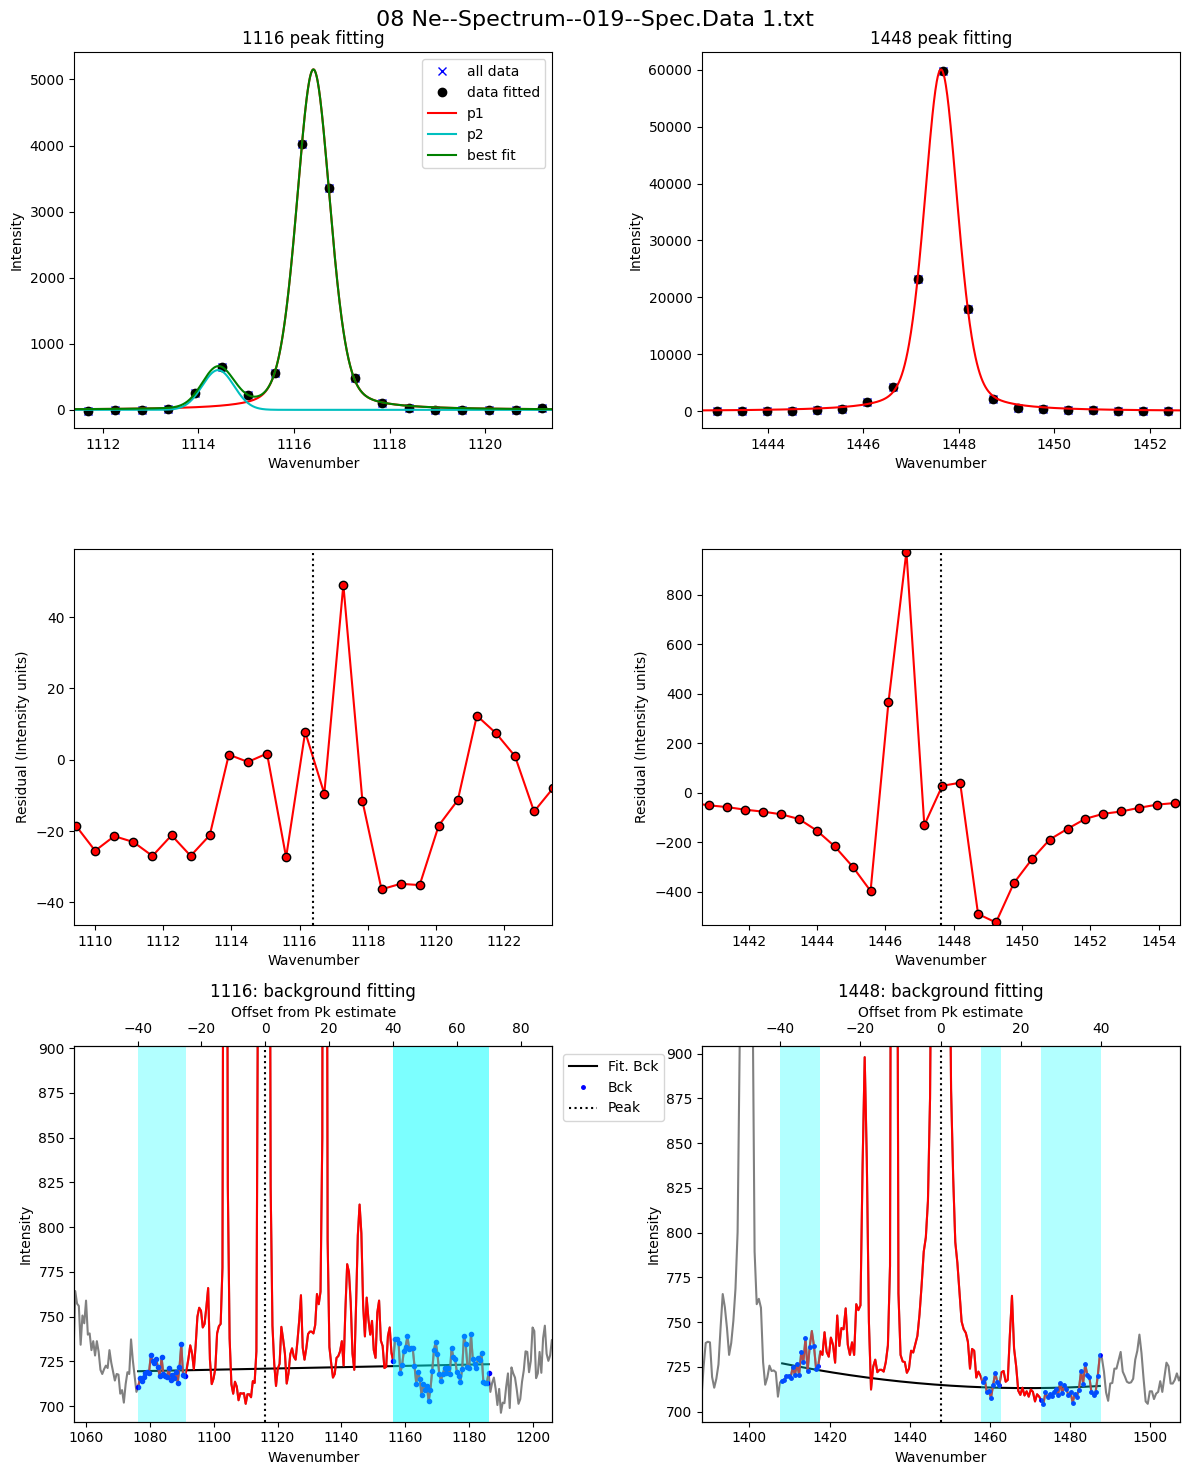

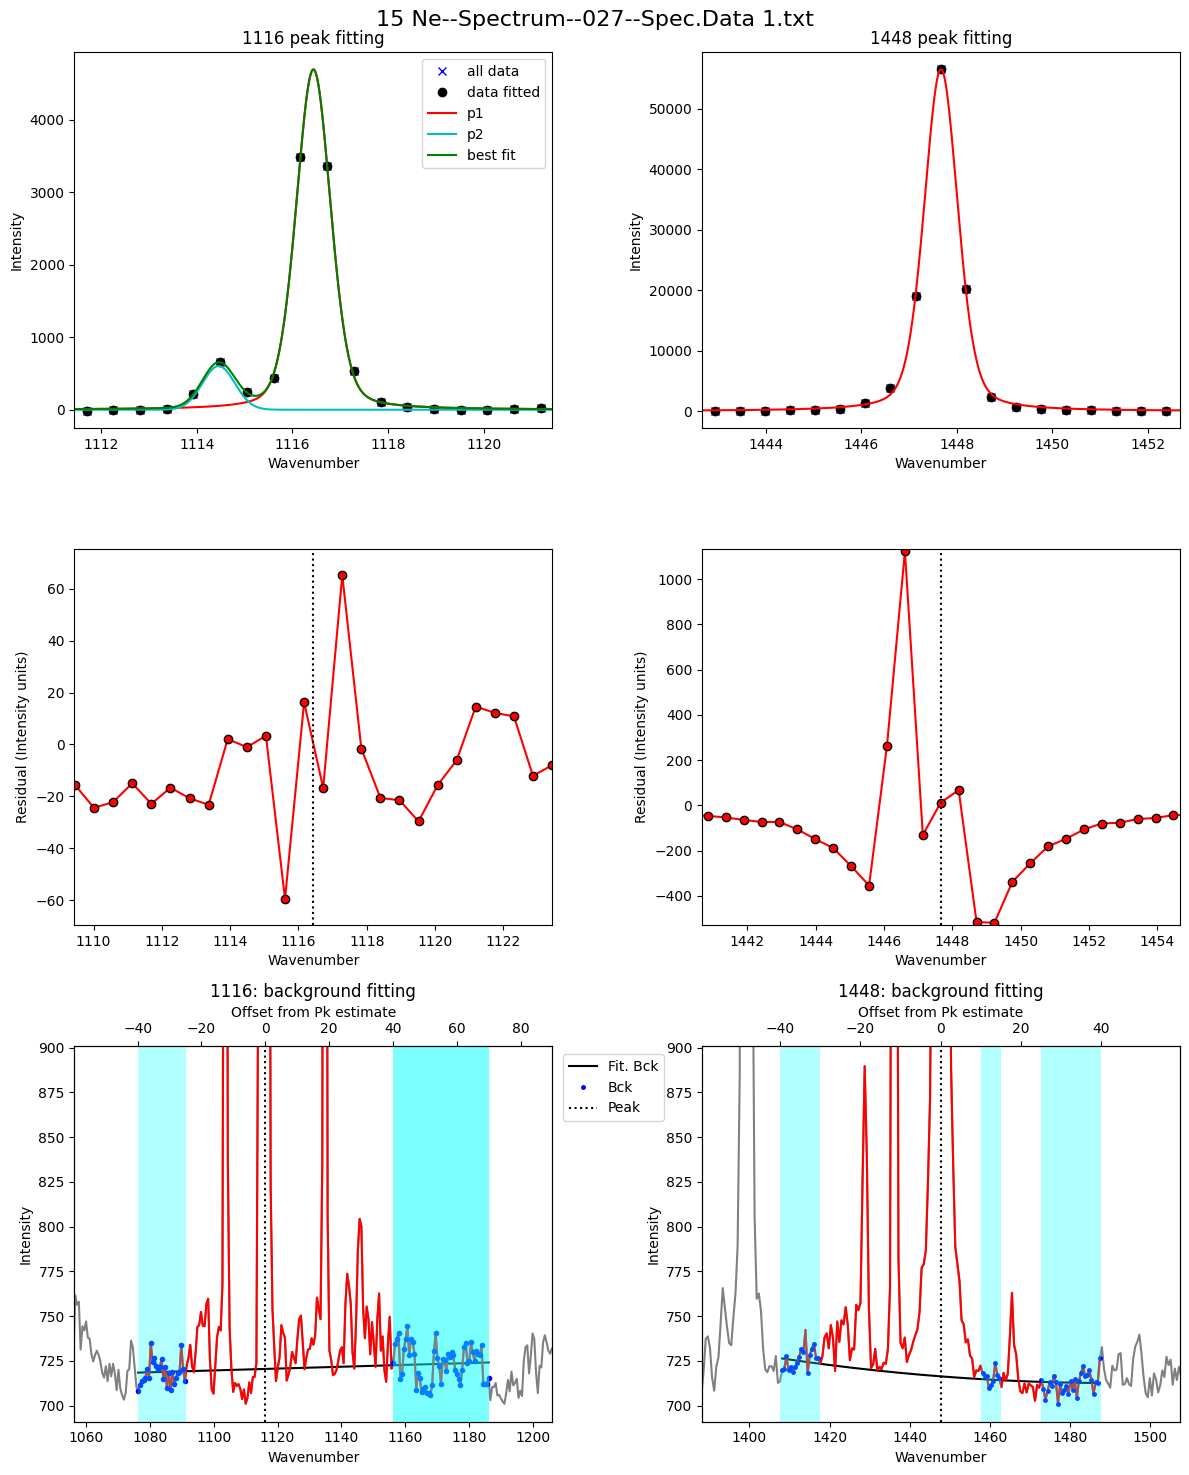

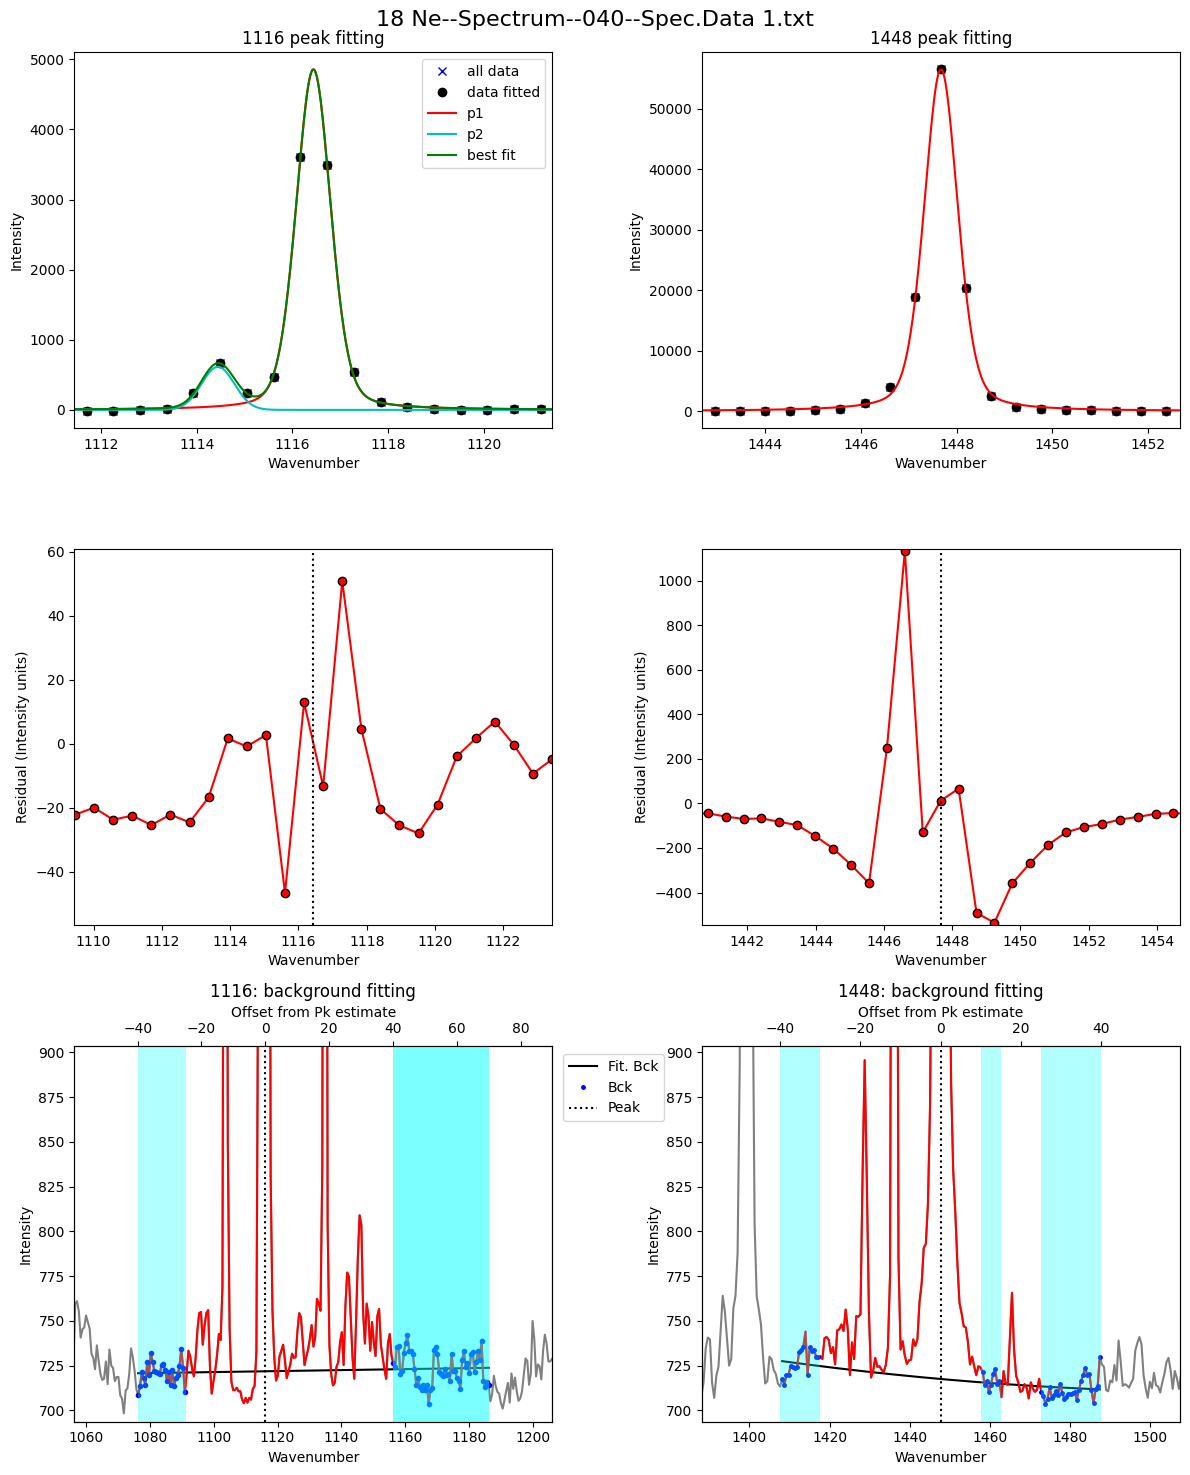

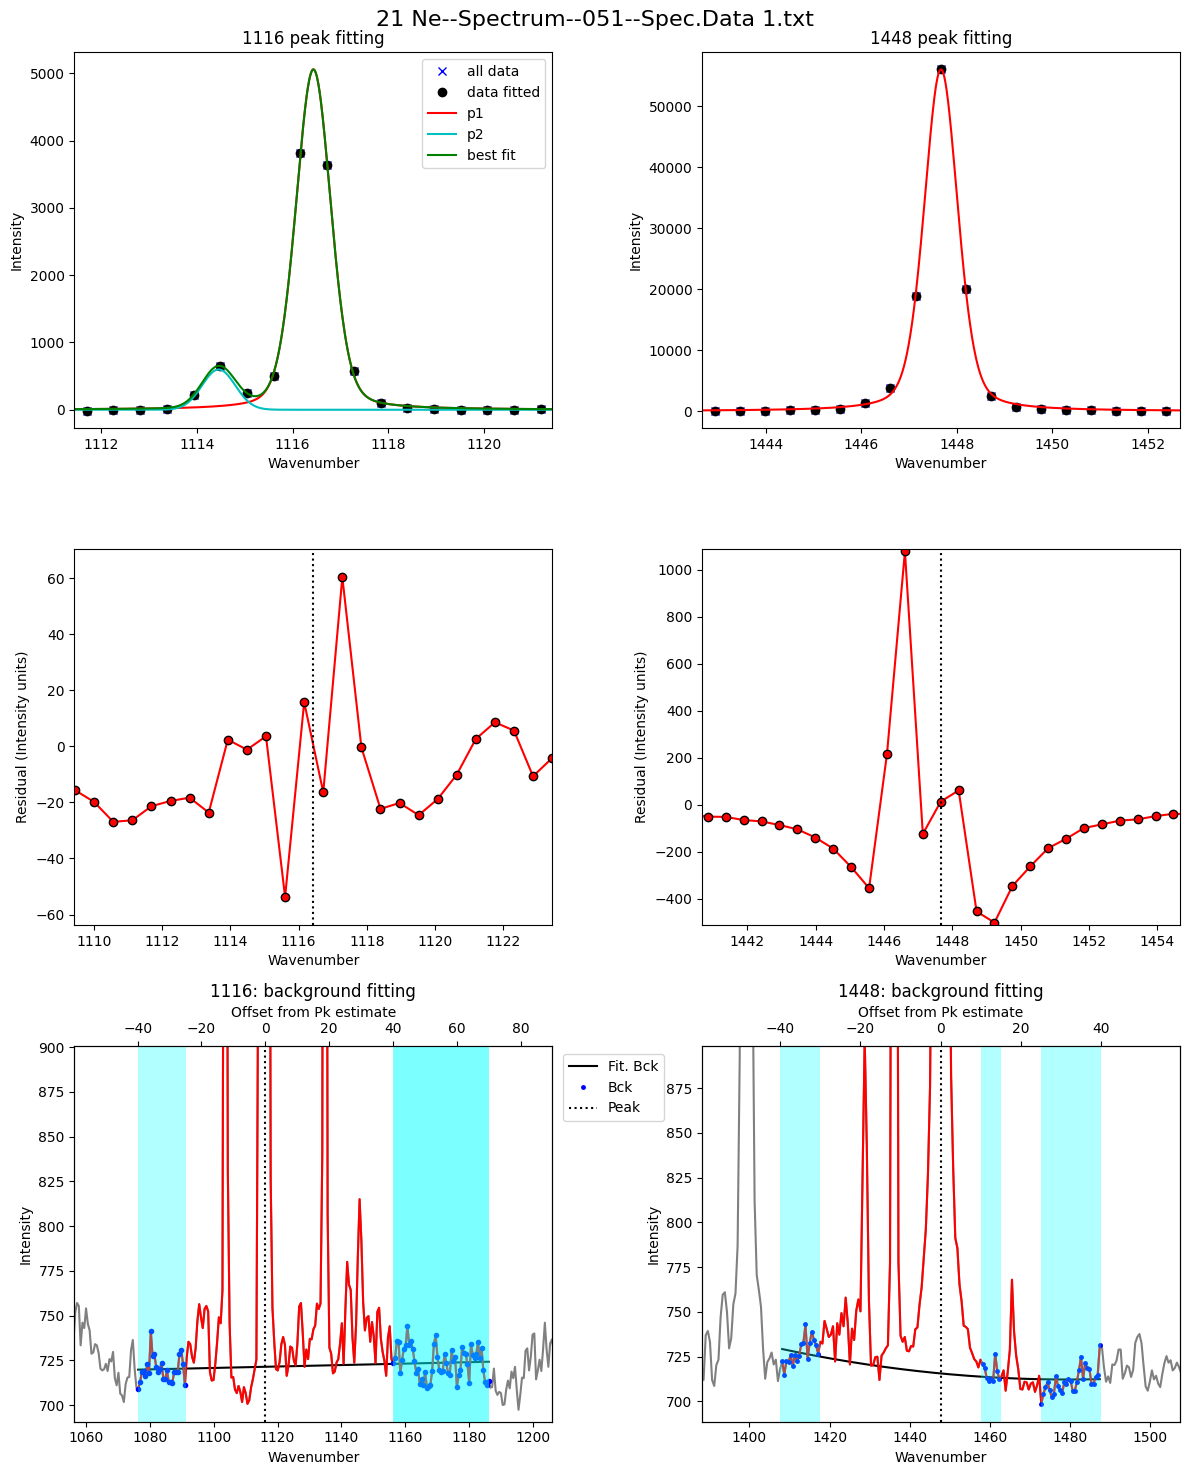

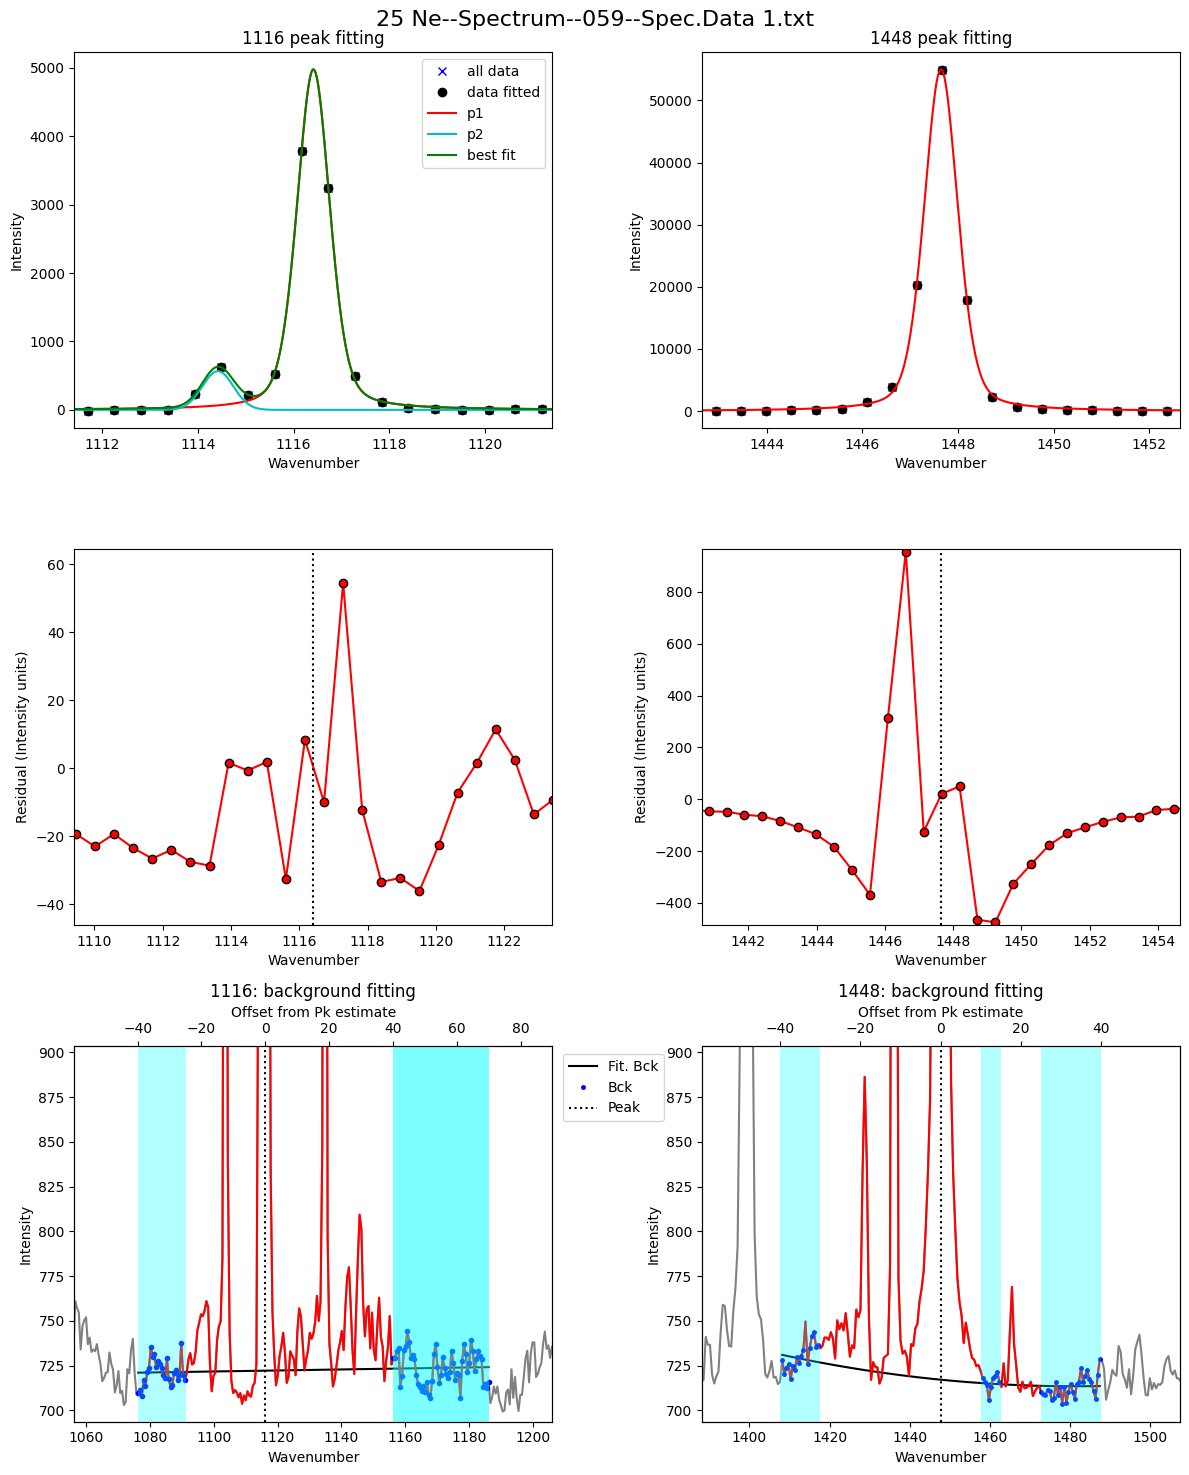

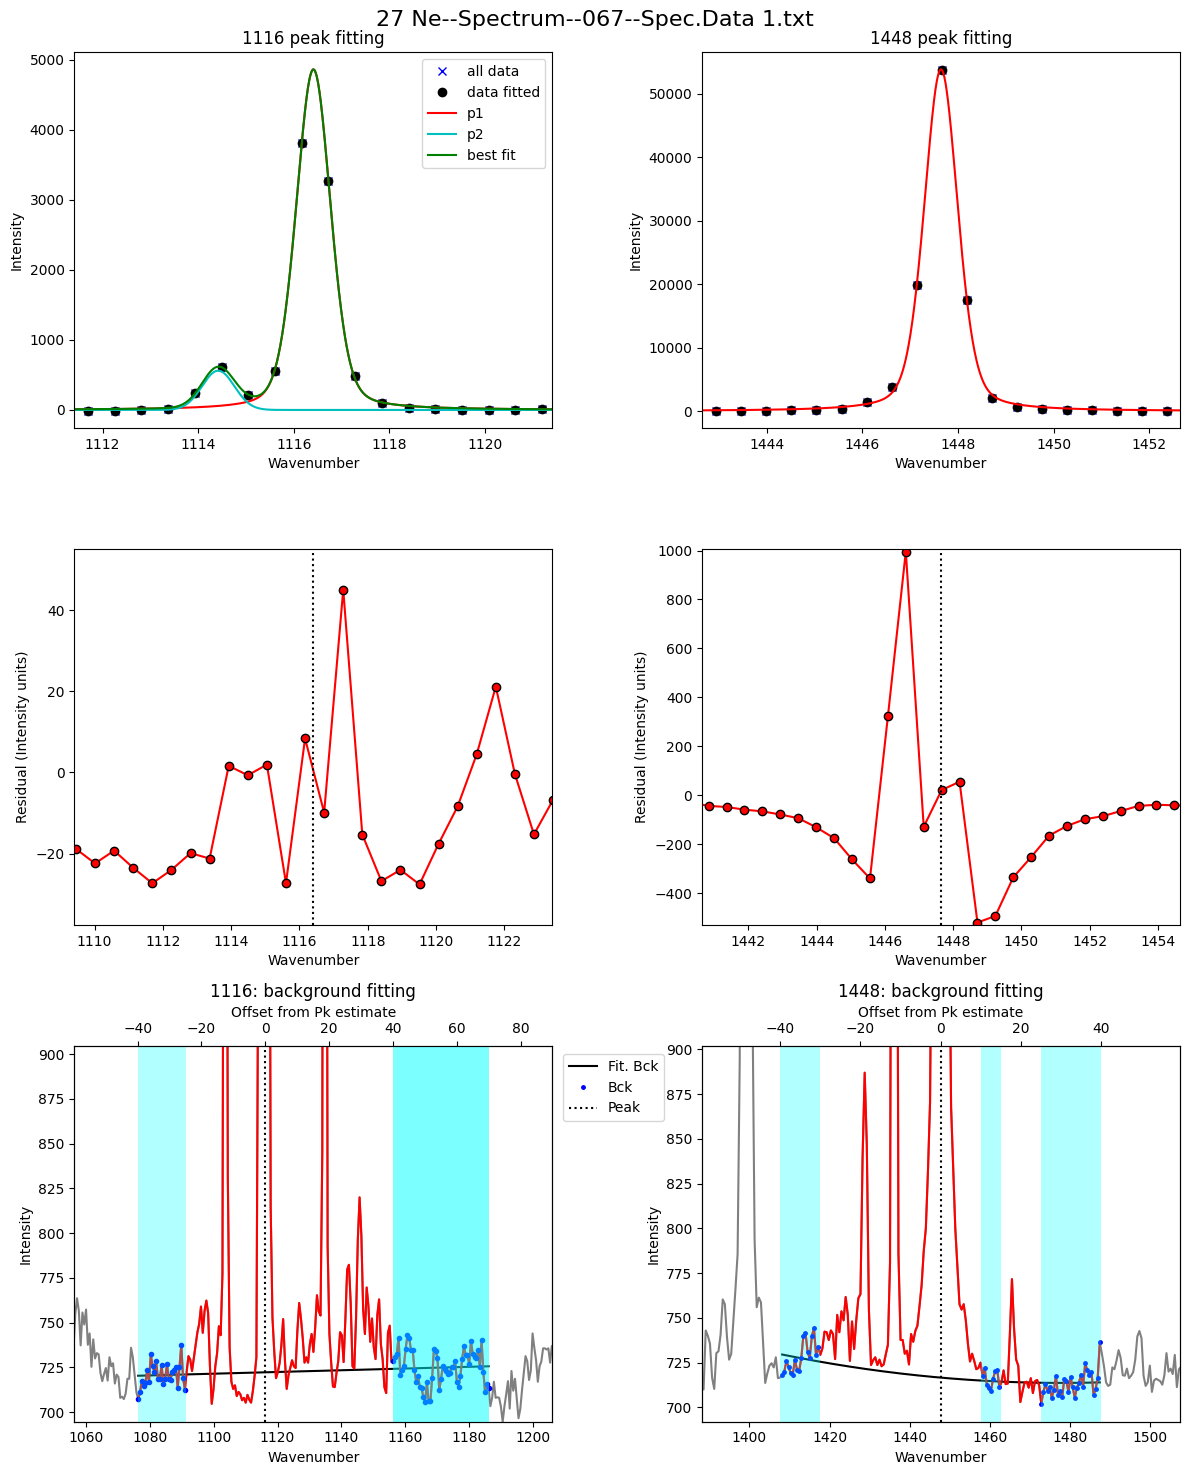

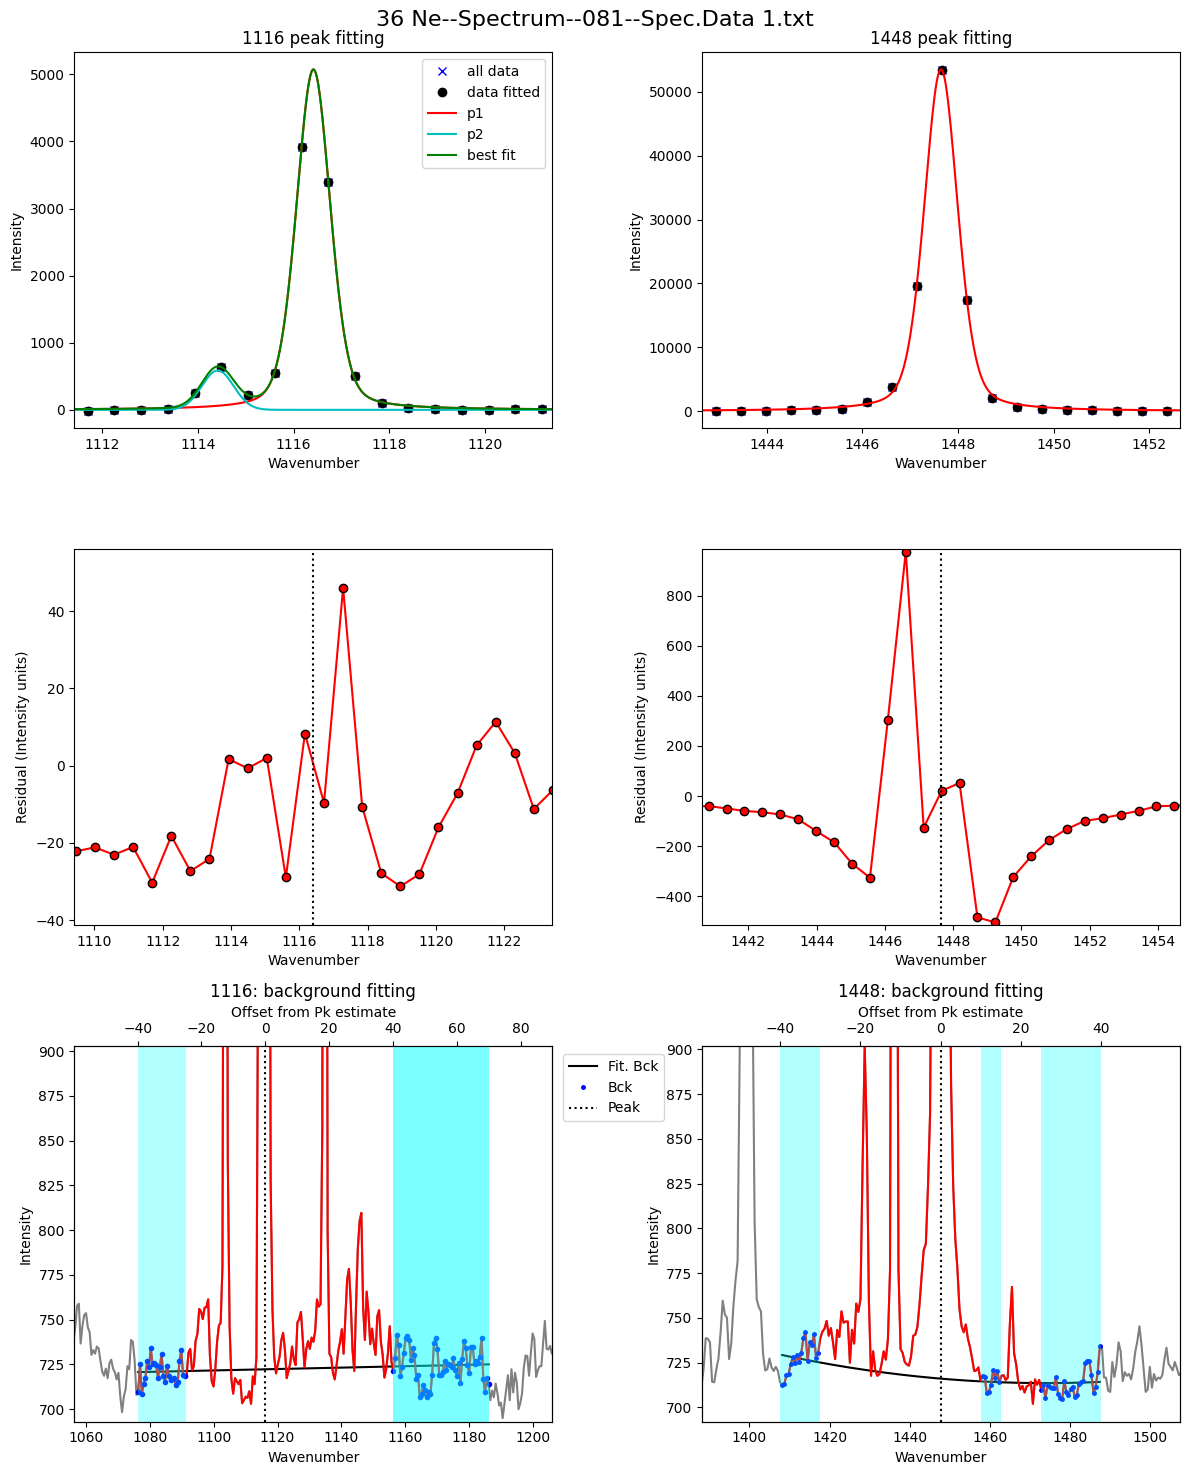

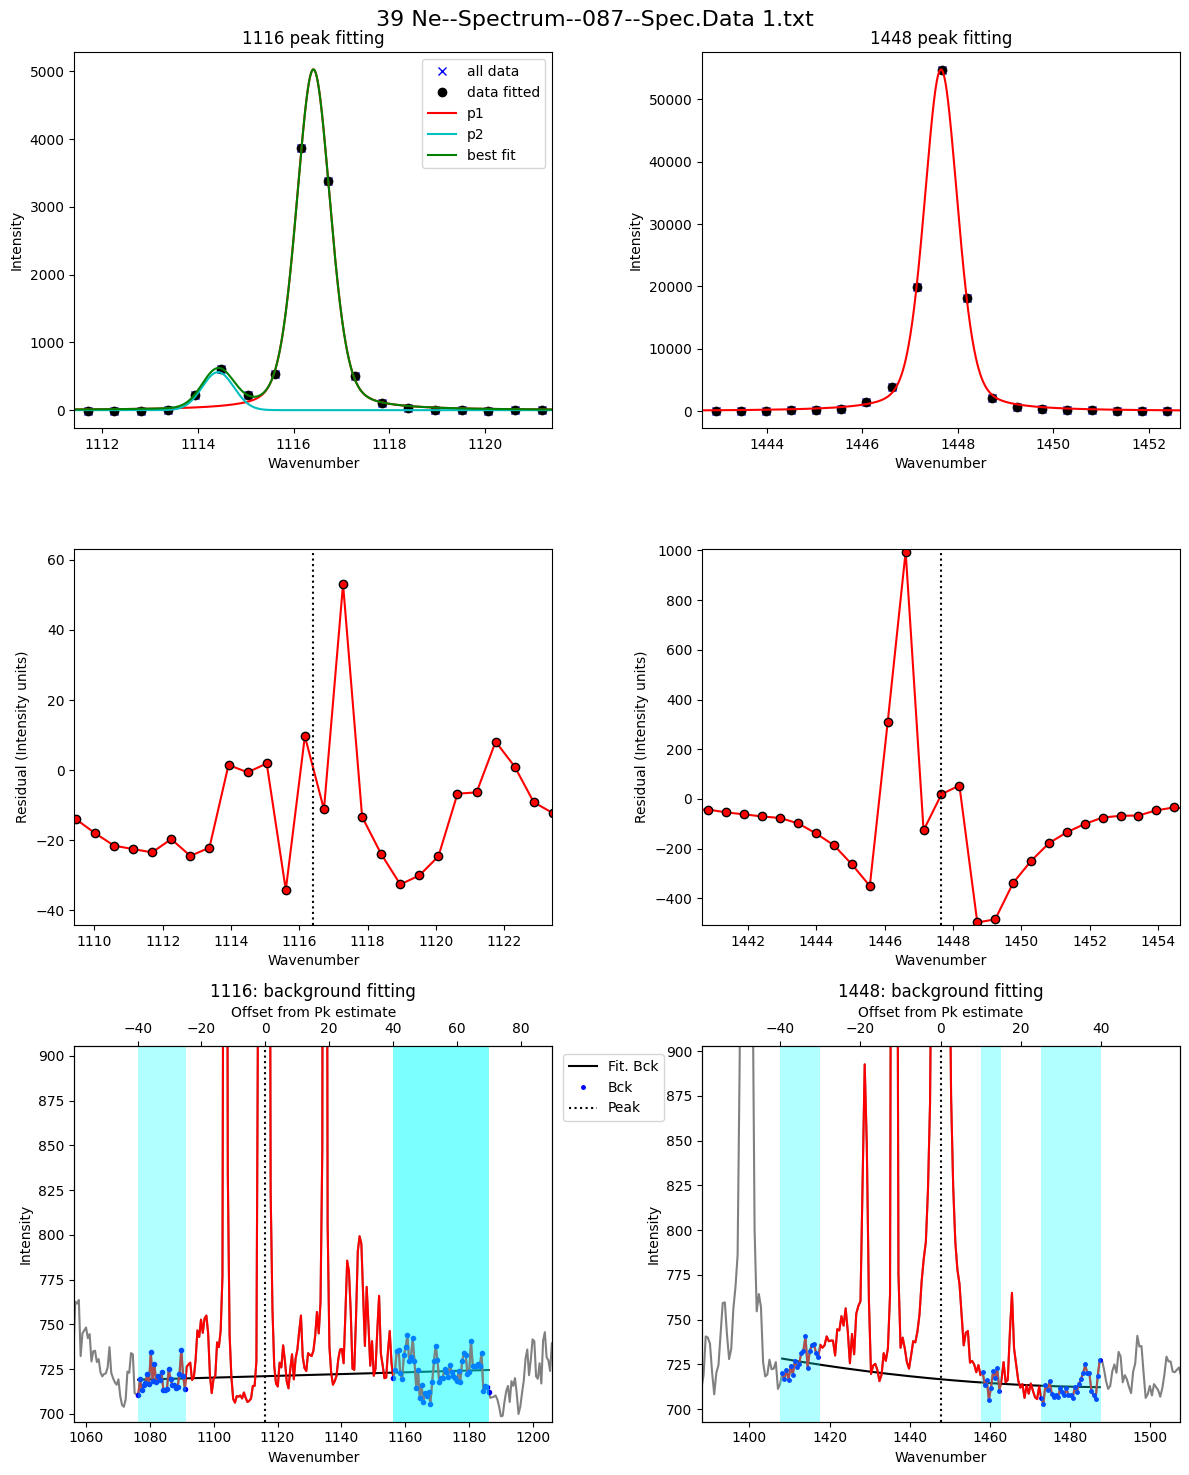

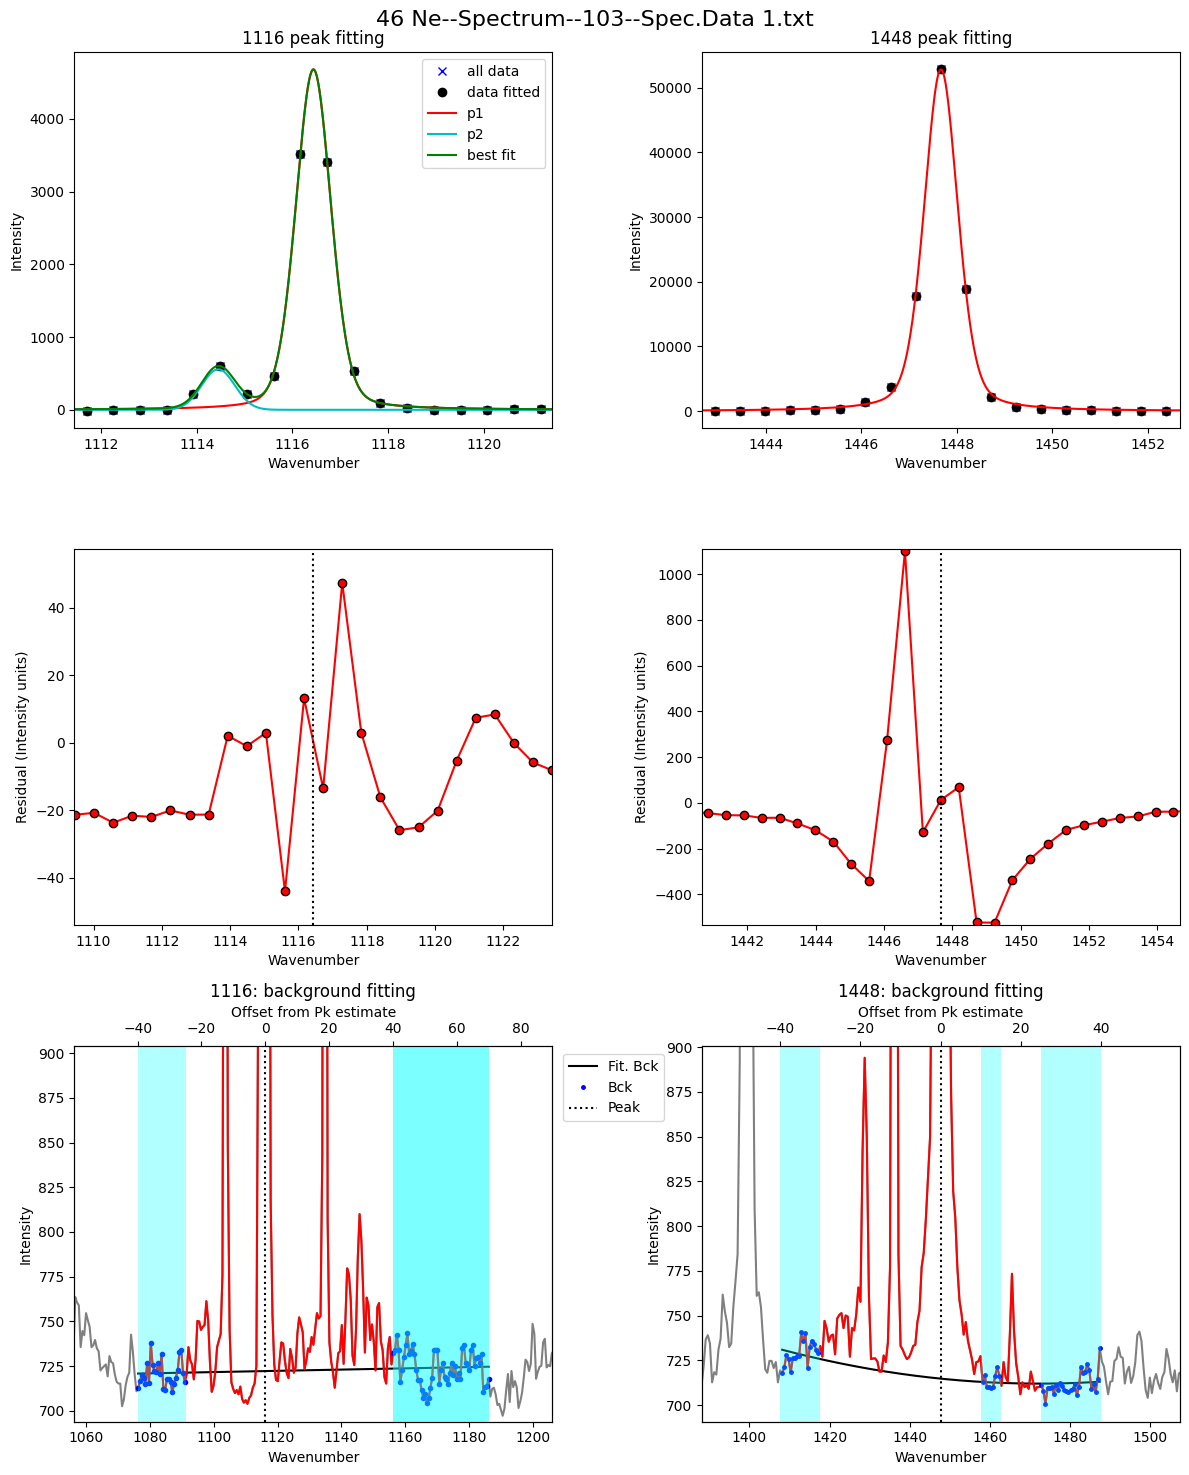

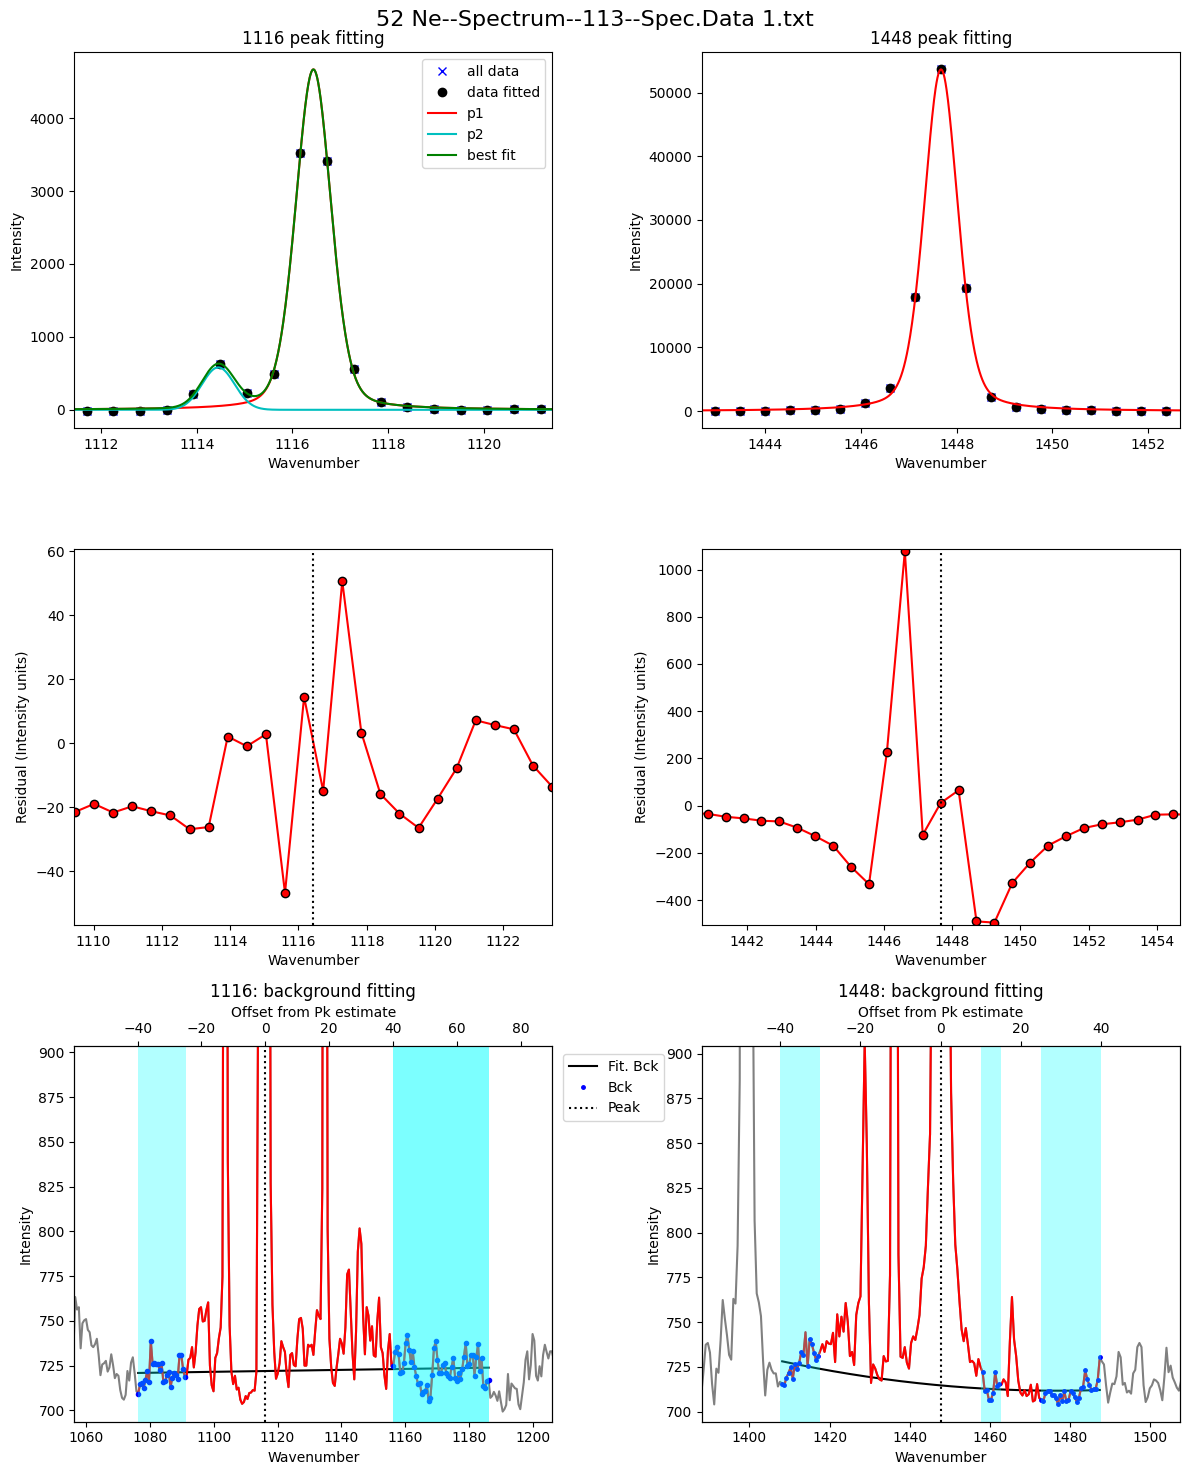

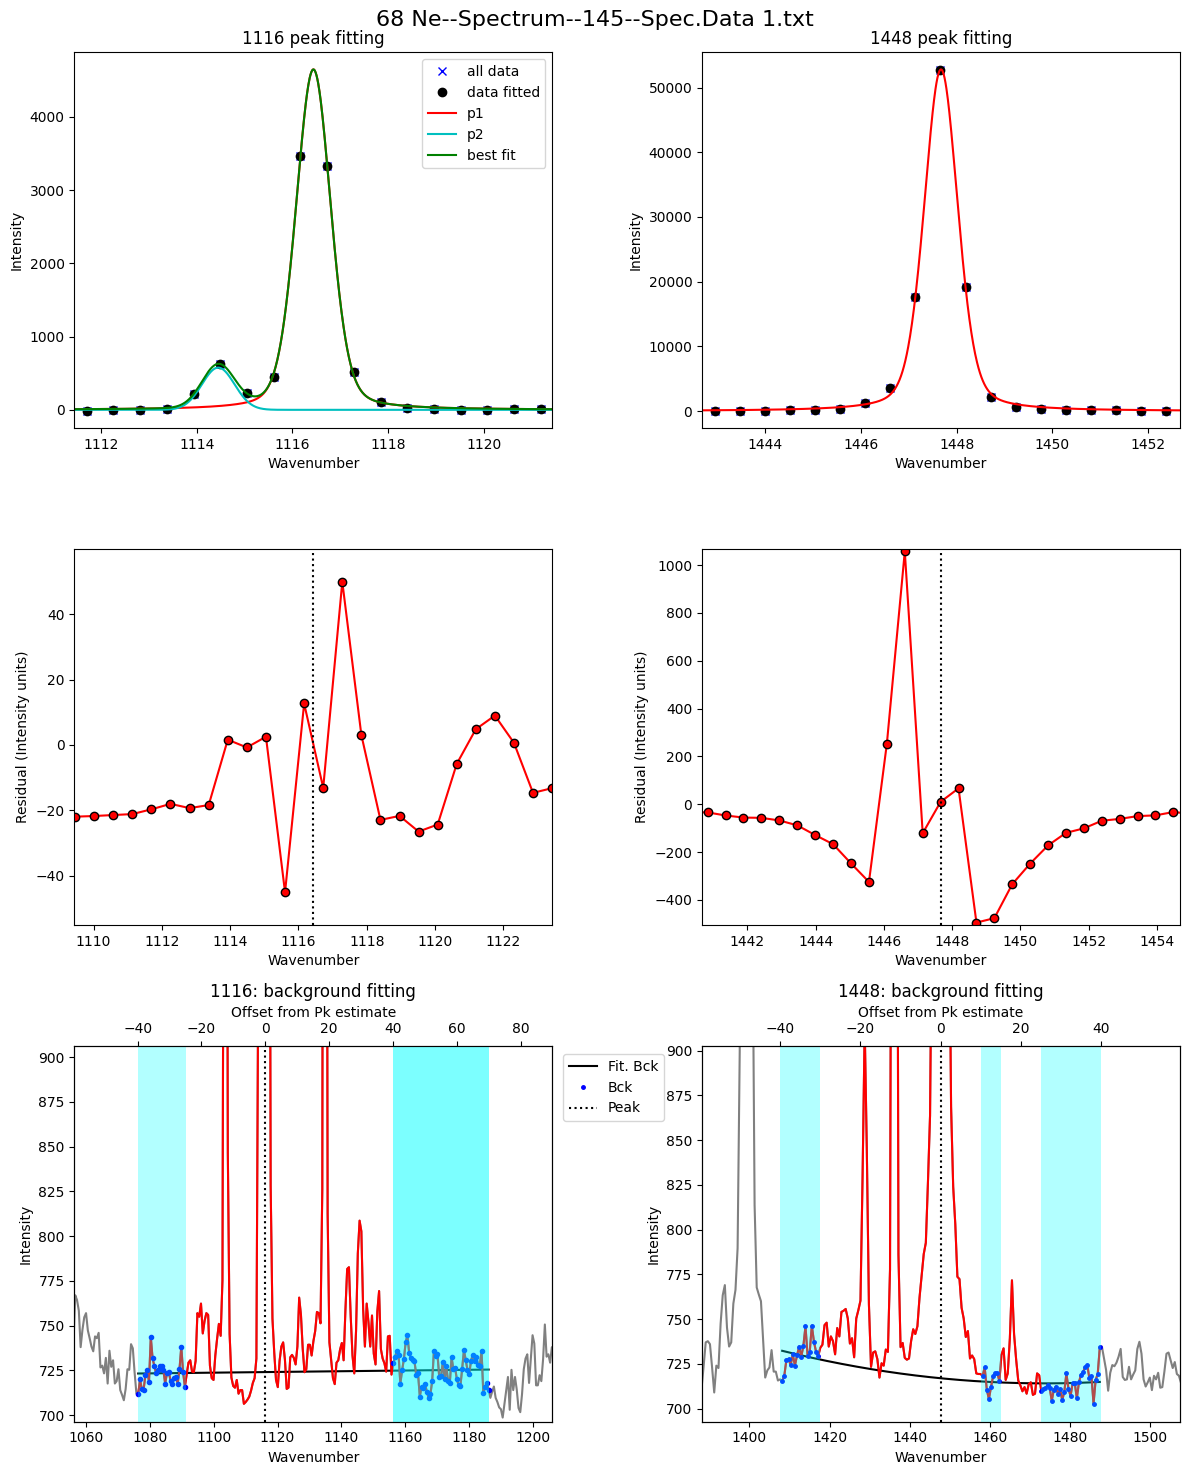

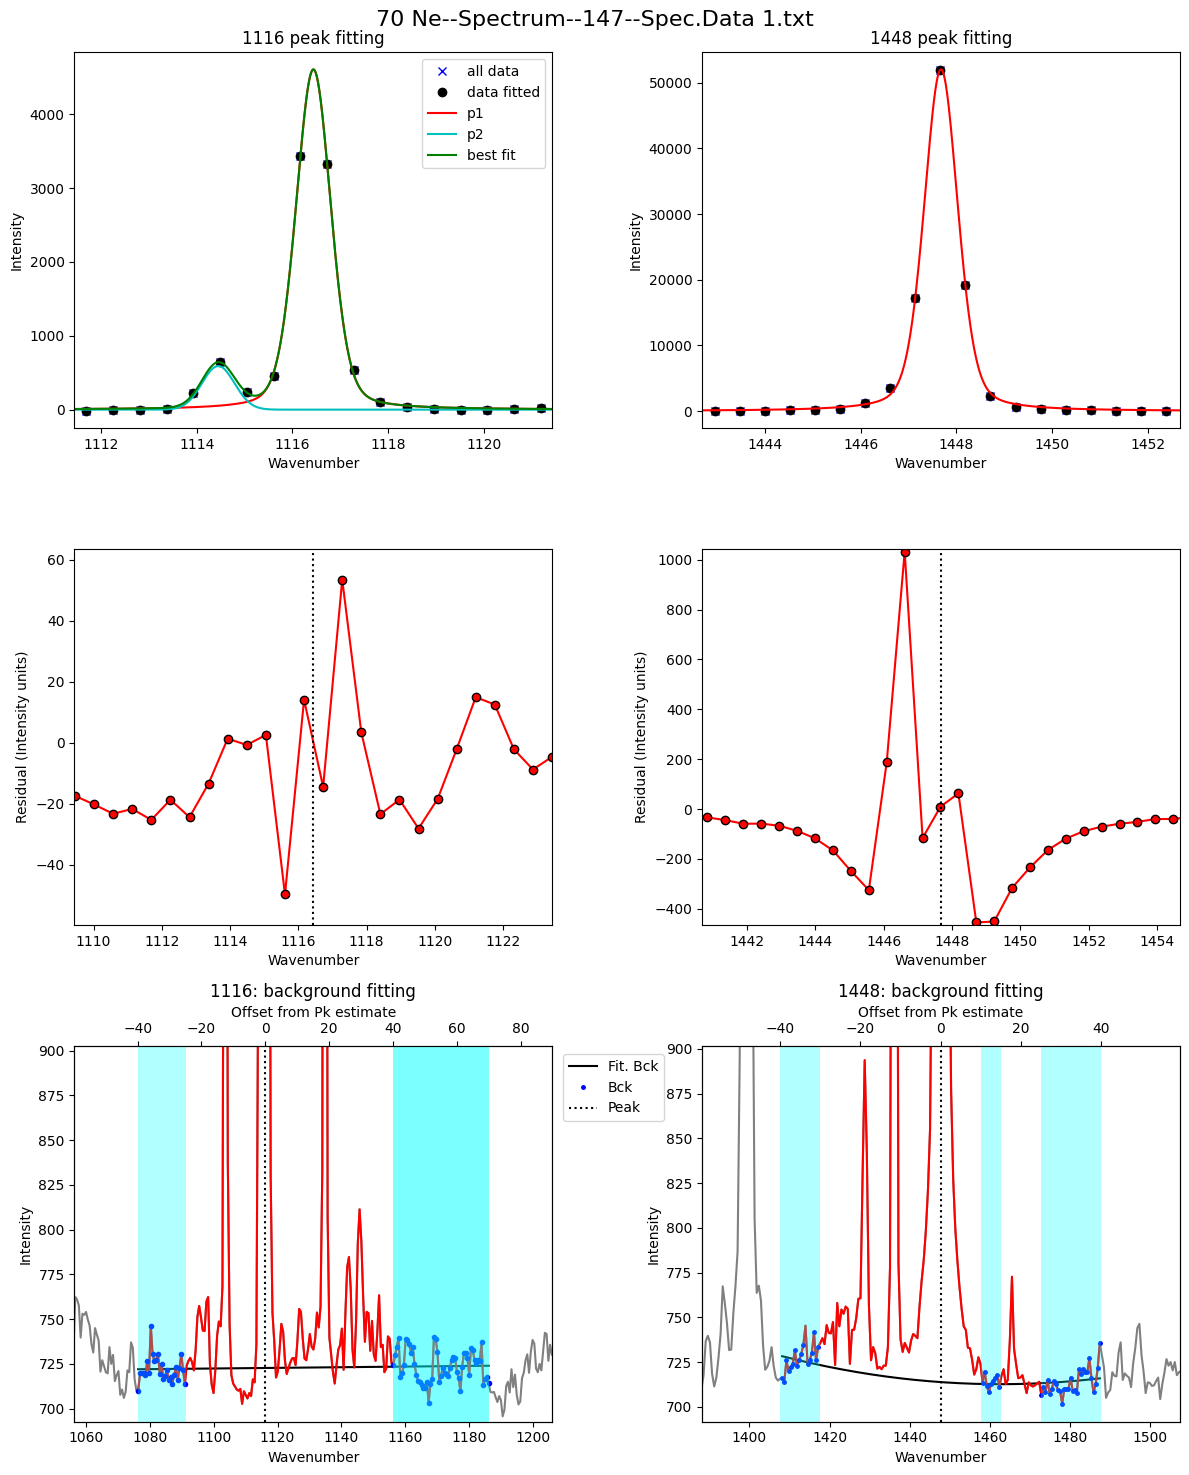

In [13]:
df2=pf.loop_Ne_lines(files=Ne_files, spectra_path=spectra_path, 
filetype=spectra_filetype, config_ID_peaks=Neon_id_config, config=Ne_Config_est,
df_fit_params=df_fit_params,  prefix=prefix,                   
plot_figure=True, const_params=True)


In [14]:
df2

filename   Ne_Corr  1σ_Ne_Corr     deltaNe  \
0             Ne--000--Spec.Data 1.txt  0.997818    0.000039  331.200388   
1   Ne--Spectrum--001--Spec.Data 1.txt  0.997799    0.000039  331.206600   
2   Ne--Spectrum--011--Spec.Data 1.txt  0.997774    0.000038  331.214759   
3   Ne--Spectrum--019--Spec.Data 1.txt  0.997759    0.000030  331.219982   
4   Ne--Spectrum--027--Spec.Data 1.txt  0.997724    0.000027  331.231629   
5   Ne--Spectrum--040--Spec.Data 1.txt  0.997719    0.000026  331.233135   
6   Ne--Spectrum--051--Spec.Data 1.txt  0.997718    0.000026  331.233667   
7   Ne--Spectrum--059--Spec.Data 1.txt  0.997726    0.000031  331.230711   
8   Ne--Spectrum--067--Spec.Data 1.txt  0.997717    0.000030  331.233885   
9   Ne--Spectrum--081--Spec.Data 1.txt  0.997726    0.000029  331.230995   
10  Ne--Spectrum--087--Spec.Data 1.txt  0.997719    0.000029  331.233110   
11  Ne--Spectrum--103--Spec.Data 1.txt  0.997730    0.000028  331.229498   
12  Ne--Spectrum--113--Spec.Data 1.txt  0.997718    0.000028  331.233381   
13  Ne--Spectrum--145--Spec.Data 1.txt  0.997710    0.000028  331.236250   
14  Ne--Spectrum--147--Spec.Data 1.txt  0.997705    0.000028  331.237735   

    pk2_peak_cent  pk1_peak_cent  pk2_amplitude  pk1_amplitude  residual_pk2  \
0     1447.567456    1116.367068   57803.811808    4707.837184    144.162729   
1     1447.589168    1116.382569   60695.692518    4761.258881    157.078386   
2     1447.616865    1116.402106   59965.859716    5110.307925    148.620729   
3     1447.626645    1116.406663   60376.675907    5152.738492    149.585351   
4     1447.670320    1116.438691   57354.541954    4764.444089    146.683706   
5     1447.672010    1116.438874   57324.560123    4922.839876    147.736623   
6     1447.670246    1116.436579   56837.118596    5162.517202    141.695582   
7     1447.644199    1116.413489   55898.481035    4984.441200    139.029907   
8     1447.644202    1116.410316   54538.747690    4959.344330    138.967709   
9     1447.645061    1116.414066   54277.780685    5126.131987    138.696827   
10    1447.648909    1116.415799   55454.560166    5084.299045    140.157967   
11    1447.668871    1116.439372   53617.844889    4775.073113    140.658555   
12    1447.672321    1116.438940   54365.927934    4840.075944    135.628456   
13    1447.674005    1116.437755   53593.600620    4731.119024    134.927305   
14    1447.677527    1116.439793   52885.291398    4721.536901    127.726242   

    residual_pk1  ...  Peak2_Prop_Lor  pk1_sigma pk1_gamma  error_pk1  \
0      13.370593  ...        0.415902   0.411715      None   0.012695   
1      14.633960  ...        0.407838   0.406752      None   0.012774   
2      21.083629  ...        0.399435   0.385232      None   0.012458   
3      17.333675  ...        0.397703   0.413967      None   0.009908   
4      17.125687  ...        0.395192   0.424390      None   0.008832   
5      15.710496  ...        0.401173   0.425735      None   0.008486   
6      17.044118  ...        0.401918   0.430809      None   0.008245   
7      17.990298  ...        0.403597   0.406546      None   0.010147   
8      16.099240  ...        0.402054   0.424149      None   0.009833   
9      15.785990  ...        0.404888   0.418077      None   0.009356   
10     16.336727  ...        0.397324   0.417810      None   0.009391   
11     15.678395  ...        0.400852   0.434034      None   0.008996   
12     16.164257  ...        0.394517   0.437337      None   0.008914   
13     15.554801  ...        0.394364   0.426955      None   0.008939   
14     16.229589  ...        0.396067   0.428765      None   0.008984   

    Peak1_Prop_Lor  Ne_Corr_min Ne_Corr_max  residual_pk1+pk2  \
0         0.372308     0.997774    0.997862        157.533321   
1         0.380305     0.997755    0.997843        171.712346   
2         0.507713     0.997732    0.997817        169.704358   
3         0.368322     0.997724    0.997794        166.919026   
4         0.340501     0.997692    0.9

## Now extract metadata to get a timestamp for each file

In [15]:
## Get meta files
Ne_files_meta=pf.get_files(path=meta_path,
file_ext=spectra_file_ext, ID_str='Ne', 
exclude_str=['diad'], sort=False)

Ne_files_meta[0:5]

['001 Ne--Spectrum--000--Information.txt',
 '002 Ne--Spectrum--001--Information.txt',
 '012 Ne--Spectrum--011--Information.txt',
 '020 Ne--Spectrum--019--Information.txt',
 '028 Ne--Spectrum--027--Information.txt']

In [16]:
# This cell stitches metadata together - e.g. gets your laser power, time stamp, accumulations etc
meta=pf.stitch_metadata_in_loop_witec(path=meta_path, 
Allfiles=Ne_files_meta, prefix=prefix, trupower=TruPower)
meta.head()

100%|██████████| 15/15 [00:04<00:00,  3.41it/s]

Done


filename                date    Month   Day  \
0  Ne--Spectrum--000--Information.txt  January 19, 2024\n  January  19.0   
1  Ne--Spectrum--001--Information.txt  January 19, 2024\n  January  19.0   
2  Ne--Spectrum--011--Information.txt  January 19, 2024\n  January  19.0   
3  Ne--Spectrum--019--Information.txt  January 19, 2024\n  January  19.0   
4  Ne--Spectrum--027--Information.txt  January 19, 2024\n  January  19.0   

   power (mW)  Int_time (s)  accumulations  Mag (X)             duration  \
0       6.017          45.0            3.0      5.0  ['0h', '2m', '19s']   
1       6.013          45.0            3.0      5.0  ['0h', '2m', '16s']   
2       5.961          45.0            3.0    100.0  ['0h', '2m', '17s']   
3       5.942          45.0            3.0     50.0  ['0h', '2m', '17s']   
4       5.898          45.0            3.0      5.0  ['0h', '2m', '17s']   

       24hr_time  sec since midnight  Spectral Center  
0  11:51:06 AM\n             42666.0         1325.004  
1  12:20:06 PM\n             44406.0         1325.004  
2  12:50:45 PM\n             46245.0         1325.004  
3   1:07:53 PM\n             47273.0         1325.004  
4   2:05:12 PM\n             50712.0         1325.004

In [17]:
# This is getting the metadata file names.  Check here the prefix has been removed. 
file_m=pf.extracting_filenames_generic(names=meta['filename'], 
   file_ext=meta_file_ext)
file_m

for i in range(len(file_m)):
    file_m[i] = file_m[i].replace("--Information", "")
file_m


good job, no duplicate file names


array(['Ne--Spectrum--000', 'Ne--Spectrum--001', 'Ne--Spectrum--011',
       'Ne--Spectrum--019', 'Ne--Spectrum--027', 'Ne--Spectrum--040',
       'Ne--Spectrum--051', 'Ne--Spectrum--059', 'Ne--Spectrum--067',
       'Ne--Spectrum--081', 'Ne--Spectrum--087', 'Ne--Spectrum--103',
       'Ne--Spectrum--113', 'Ne--Spectrum--145', 'Ne--Spectrum--147'],
      dtype=object)

In [18]:
# This is getting the spectra file names. Check that they are in the same format as the metadataones above, this is what you need to successfully stitch together. 
file_s=pf.extracting_filenames_generic(names=df2['filename'],
   file_ext=spectra_file_ext)
file_s

for i in range(len(file_s)):
    file_s[i] = file_s[i].replace("--Spec.Data 1", "")
file_s

good job, no duplicate file names


array(['Ne--000', 'Ne--Spectrum--001', 'Ne--Spectrum--011',
       'Ne--Spectrum--019', 'Ne--Spectrum--027', 'Ne--Spectrum--040',
       'Ne--Spectrum--051', 'Ne--Spectrum--059', 'Ne--Spectrum--067',
       'Ne--Spectrum--081', 'Ne--Spectrum--087', 'Ne--Spectrum--103',
       'Ne--Spectrum--113', 'Ne--Spectrum--145', 'Ne--Spectrum--147'],
      dtype=object)

## Combine 2 dataframes
- Here we add a new column to each dataframe with these stripped back names, and then merge the 2 dataframes

In [19]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')
print('Number merged= '+str(len(df_combo))+', Check this is what you expected, else check file_m and file_s look the same')

Number merged= 14, Check this is what you expected, else check file_m and file_s look the same


## Now lets inspect changes in Ne correction factor with time
- Normally, you can spot outliers this way

In [20]:
df_combo_sort=df_combo.sort_values(by='sec since midnight')
df_combo_sort.to_excel('PseudoVoigt.xlsx')

In [21]:
0.4/df_combo['error_pk2']

0     224.704497
1     226.664939
2     228.671094
3     217.108874
4     215.038236
5     214.868308
6     217.746648
7     210.359291
8     213.174610
9     216.599521
10    201.114430
11    213.121246
12    208.811447
13    207.659671
Name: error_pk2, dtype: float64

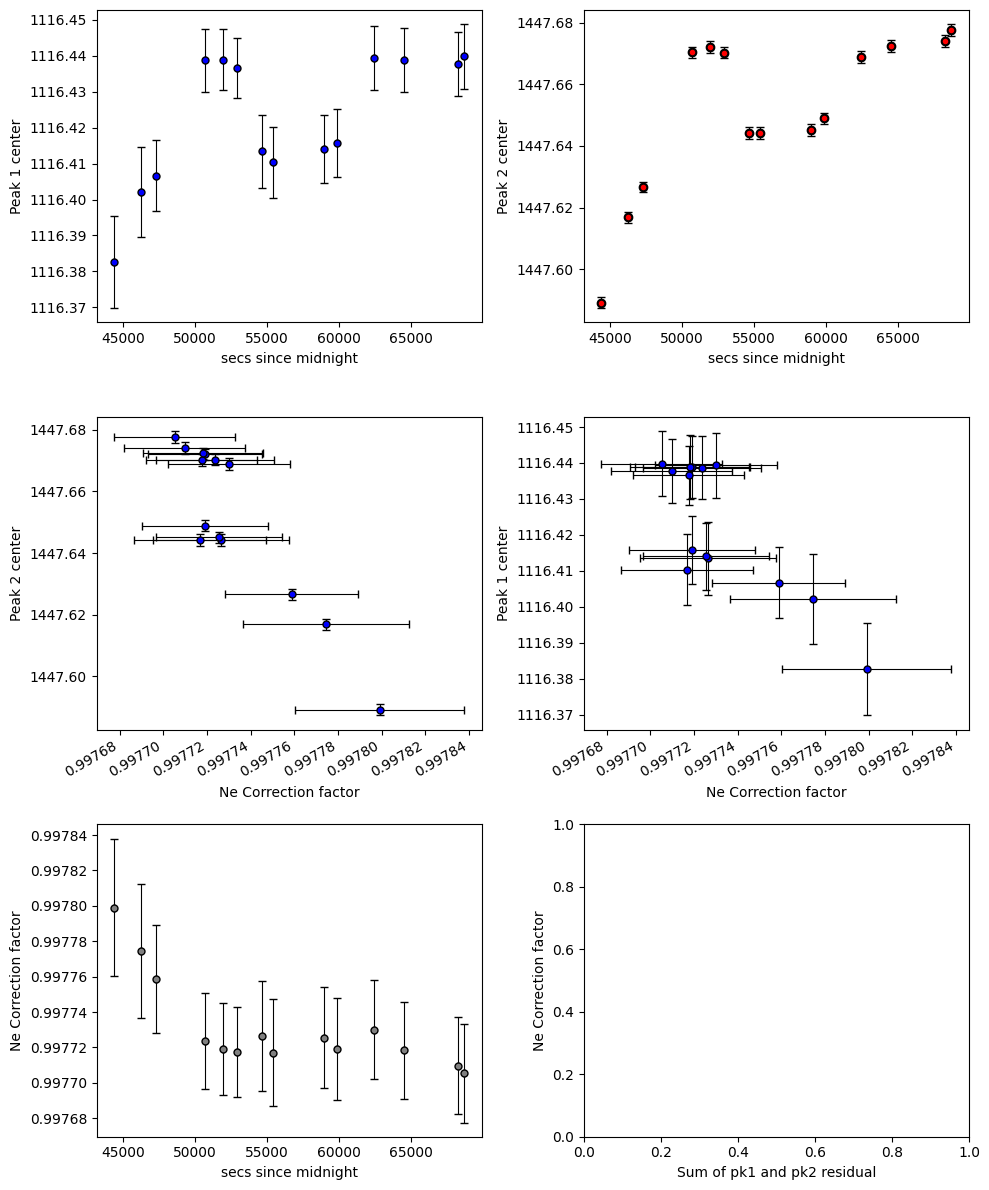

In [22]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')


In [23]:
103.2*0.9979

102.98328000000001

## Exclude ones that don't look right...
- The filter_Ne_Line_neighbours excludes Ne lines that have a correction factor more than "offset" from their N neighbours (defined by "number_av")
- Tweak offset and number_av until you exclude the ones that dont look right
- Smaller number of offset - more discarded
- If you notice really bad fits, you can also exclude certain files like file_name_filt=['Ne_line_1.txt'], or file_name_filt=['Ne_line_2.txt', 'Ne_line_5.txt']

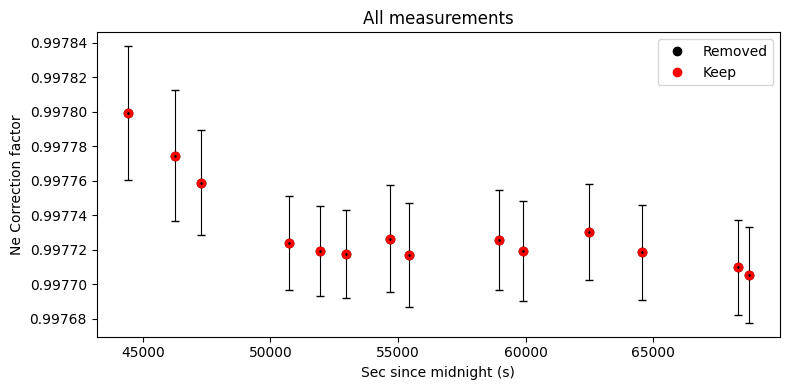

In [24]:
filt=pf.filter_Ne_Line_neighbours(df_combo=df_combo, 
                    number_av=3, offset=0.001, file_name_filt=None)
# Now lets plot this to see
fig, (ax1) = plt.subplots(1, 1, figsize=(8,4))
ax1.errorbar(df_combo['sec since midnight'], df_combo['Ne_Corr'], xerr=0, 
yerr=df_combo['1σ_Ne_Corr'], fmt='d', ecolor='k', elinewidth=0.8, mfc='cyan', ms=1, mec='k', capsize=3)
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='Removed')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Keep')

ax1.legend()

ax1.set_xlabel('Sec since midnight (s)')
ax1.set_ylabel('Ne Correction factor')
ax1.set_title('All measurements')

fig.tight_layout()

## Now lets make a regression against time
- We take this time regression and then apply to our diad fits

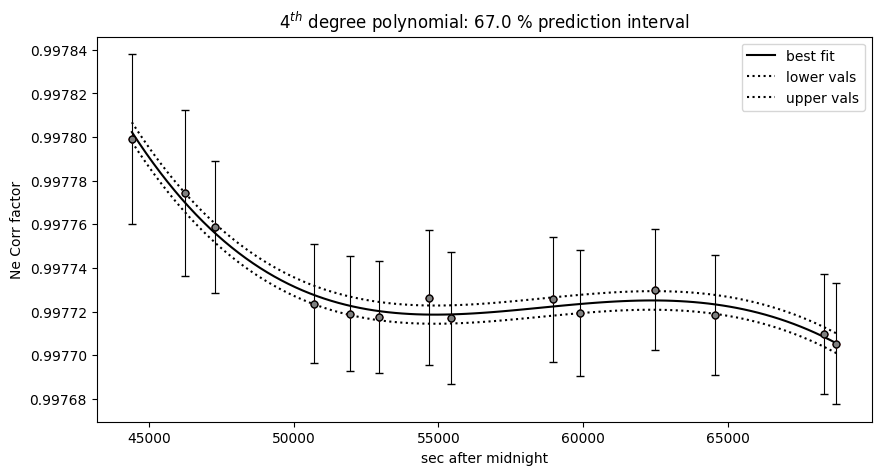

In [27]:

big_err=df_combo['1σ_Ne_Corr']>0.0001
## Lets get filtered ones
keep=(filt>0)&(~big_err)

pf.generate_Ne_corr_model(time=df_combo['sec since midnight'].loc[keep], Ne_corr=df_combo.loc[keep], 
N_poly=4, CI=0.67, pkl_name='Neon_corr_model.pkl')


In [28]:
import os

if os.name=="posix":

    def mac_notification(title, subtitle, message):
        """
        Display a macOS notification with the default sound using AppleScript.
        
        Args:
        - title: Title of the notification.
        - subtitle: Subtitle of the notification.
        - message: Main message content of the notification.
        """
        os.system("""
                osascript -e 'display notification "{}" with title "{}" subtitle "{}" sound name "default"'
                """.format(message, title, subtitle))

    mac_notification("Notebook Completed", "VSCode", "Step1 Ne lines")

else:

    # %pip install winotify

    from winotify import Notification, audio

    toast= Notification(app_id="VSCode",title="Notebook completed",
                        msg="Step1 Ne lines is done!",
                        duration="short")
    toast.set_audio(audio.Mail,loop=False)
    toast.show()